In [1]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np      
from gprofiler import GProfiler
from scipy import stats
import umap
import wgcna as wgcna
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import spearmanr
import seaborn as sns
from scipy.spatial.distance import squareform

C:\Users\BEK\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# loading   gene expression cluster data data downloaded from TCGa

# Load the TSV file
file_path = "C:\\Users\\BEK\\Desktop\\glioma\\glio.tsv"
# Read the file
df = pd.read_csv(file_path, sep="\t")


In [3]:
# Separate the dataframe into normal and tumor cases based on 'Tissue type'
df_normal = df[df['Tissue type'] == 'Normal']
df_tumor = df[df['Tissue type'] == 'Tumor']

print(f"Normal cases: {df_normal.shape[0]}")
print(f"Tumor cases: {df_tumor.shape[0]}")

Normal cases: 110
Tumor cases: 177


PERFORMINF PCA 

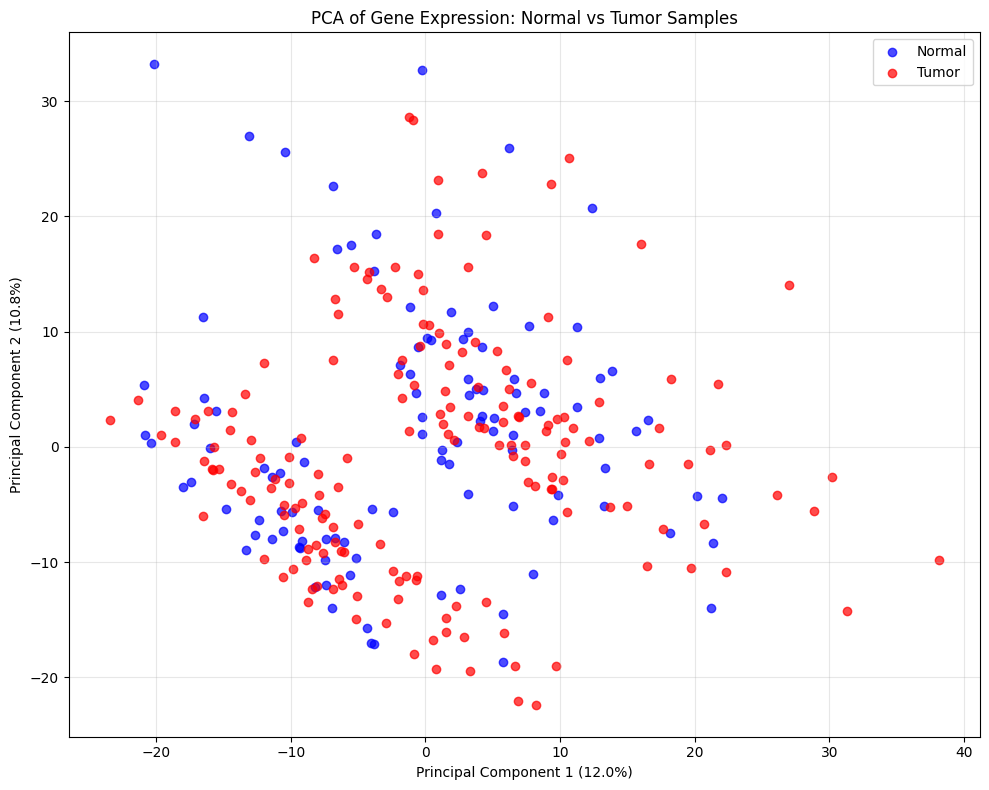

In [4]:
# Get only gene columns (exclude metadata columns)
gene_cols = df.columns.difference(['Case', 'State', 'Disease type', 'Tissue type'])

# Prepare data for PCA
X = df[gene_cols]

# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)

# Create DataFrame with principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Tissue type'] = df['Tissue type']

# Calculate explained variance ratio
explained_variance = pca.explained_variance_ratio_ * 100

# Create PCA plot
plt.figure(figsize=(10, 8))
colors = {'Normal': 'blue', 'Tumor': 'red'}

for tissue_type in ['Normal', 'Tumor']:
    mask = pca_df['Tissue type'] == tissue_type
    plt.scatter(pca_df.loc[mask, 'PC1'], 
               pca_df.loc[mask, 'PC2'],
               c=colors[tissue_type],
               label=tissue_type,
               alpha=0.7)

plt.xlabel(f'Principal Component 1 ({explained_variance[0]:.1f}%)')
plt.ylabel(f'Principal Component 2 ({explained_variance[1]:.1f}%)')
plt.title('PCA of Gene Expression: Normal vs Tumor Samples')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

PERFORMING UMAP

C:\Users\BEK\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\BEK\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


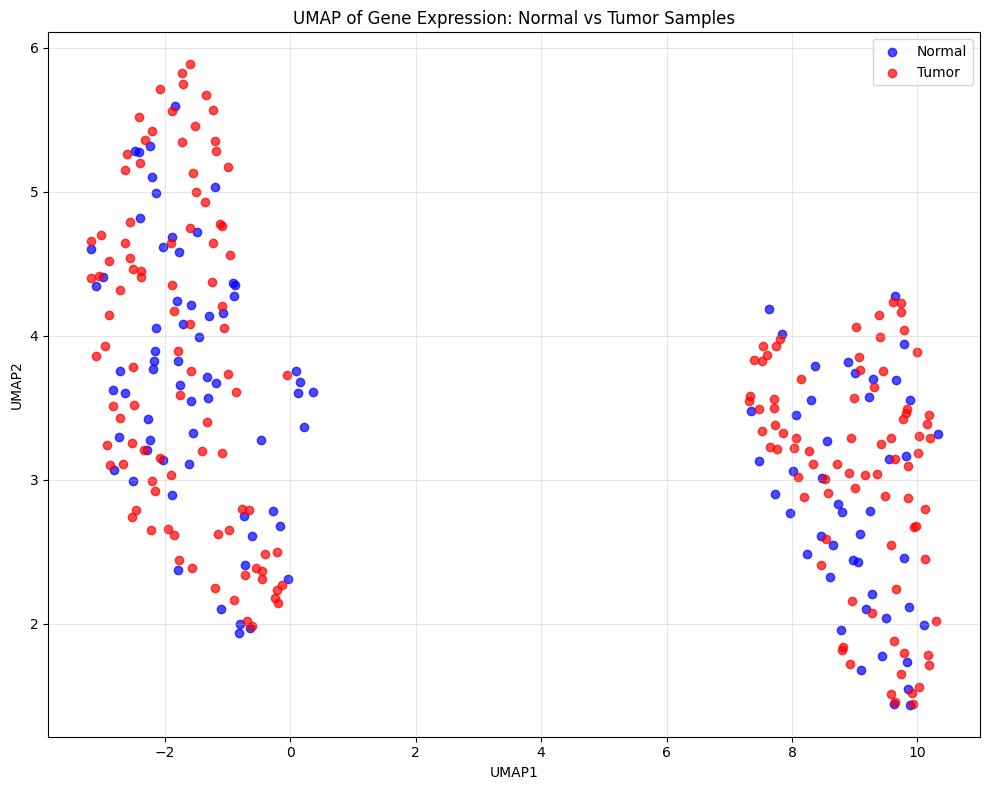

In [5]:

# Create UMAP object
reducer = umap.UMAP(random_state=42)

# Perform UMAP on gene expression data
umap_components = reducer.fit_transform(X)

# Create DataFrame with UMAP components
umap_df = pd.DataFrame(data=umap_components, columns=['UMAP1', 'UMAP2'])
umap_df['Tissue type'] = df['Tissue type']

# Create UMAP plot
plt.figure(figsize=(10, 8))
colors = {'Normal': 'blue', 'Tumor': 'red'}

for tissue_type in ['Normal', 'Tumor']:
    mask = umap_df['Tissue type'] == tissue_type
    plt.scatter(umap_df.loc[mask, 'UMAP1'], 
               umap_df.loc[mask, 'UMAP2'],
               c=colors[tissue_type],
               label=tissue_type,
               alpha=0.7)

plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP of Gene Expression: Normal vs Tumor Samples')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

performing differential gene expression analysis to identify genes that are up- or down-regulated in tumor samples compared to normal samples.

In [6]:


# Get only gene columns (exclude metadata columns)
gene_cols = df_normal.columns.difference(['Case', 'State', 'Disease type', 'Tissue type'])


# Calculate mean expression for each gene in normal and tumor
mean_normal = df_normal[gene_cols].mean()
mean_tumor = df_tumor[gene_cols].mean()

# Add a small constant to shift means to positive values
epsilon = 1e-18
mean_normal_shifted = mean_normal + abs(mean_normal.min()) + epsilon
mean_tumor_shifted = mean_tumor + abs(mean_normal.min()) + epsilon

log2_fc_all = np.log2(mean_tumor_shifted / mean_normal_shifted)
log2_fc_df = pd.DataFrame({'log2_fold_change': log2_fc_all}, index=gene_cols)
log2_fc_df.head()


,log2_fold_change
ABCA1,0.711507
ABCC3,1.662258
ACBD7,-0.214018
ACKR1,-0.590080
ACSBG1,0.147282


Generating a vocalno plot to visualize genes that have significant fold expression either upregulated or down regulated 

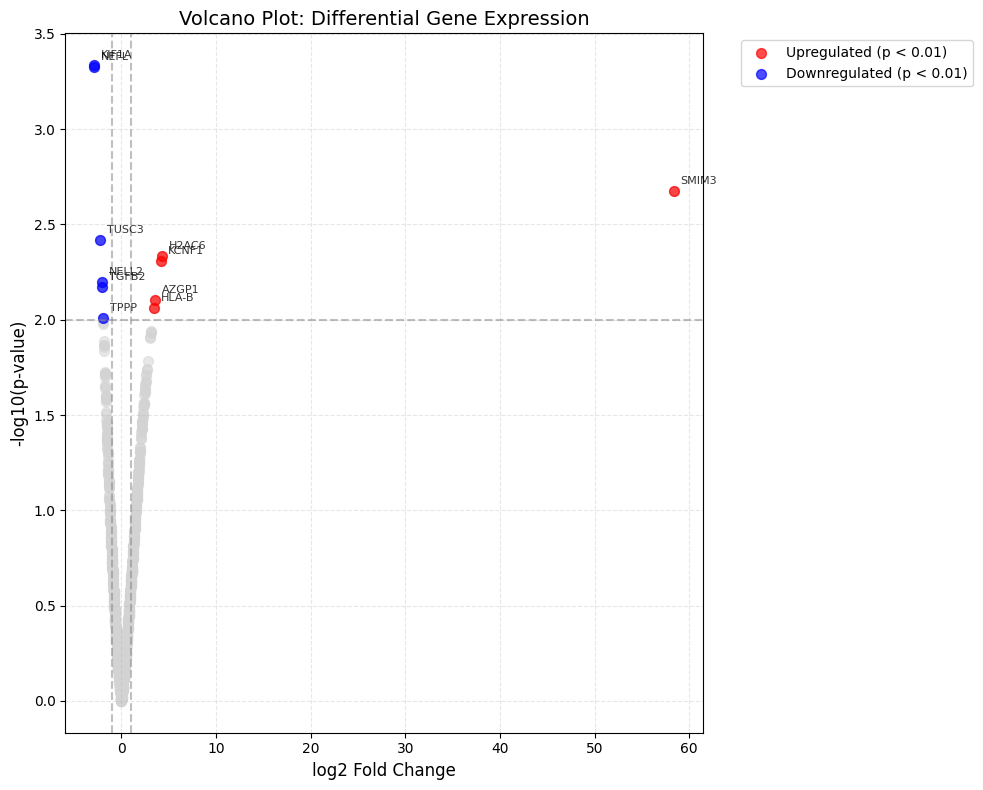

In [7]:


# Calculate p-values for each gene
p_values = []
log10_p_values = []

for gene in gene_cols:
    normal_values = df_normal[gene]
    tumor_values = df_tumor[gene]
    t_stat, p_val = stats.ttest_ind(normal_values, tumor_values)
    p_values.append(p_val)
    log10_p_values.append(-np.log10(p_val))

# Add p-values to the dataframe
log2_fc_df['p_value'] = p_values
log2_fc_df['-log10_p_value'] = log10_p_values

# Define thresholds
fc_thresh = 1
pval_thresh = 0.01

# Get significant genes
significant_genes = log2_fc_df[(log2_fc_df['p_value'] < pval_thresh) & 
                              (abs(log2_fc_df['log2_fold_change']) > fc_thresh)]
significant_genes = significant_genes.reset_index().rename(columns={'index': 'Genes'})

# Split into up/down regulated
upregulated_genes = significant_genes[significant_genes['log2_fold_change'] > 0]
downregulated_genes = significant_genes[significant_genes['log2_fold_change'] < 0]

# Create volcano plot
plt.figure(figsize=(10, 8))

# Plot all points in grey first
plt.scatter(
    log2_fc_df['log2_fold_change'],
    -np.log10(log2_fc_df['p_value']),
    c='lightgrey',
    alpha=0.5,
    s=50
)

# Plot significant genes
plt.scatter(
    upregulated_genes['log2_fold_change'],
    -np.log10(upregulated_genes['p_value']),
    c='red',
    alpha=0.7,
    s=50,
    label='Upregulated (p < 0.01)'
)

plt.scatter(
    downregulated_genes['log2_fold_change'],
    -np.log10(downregulated_genes['p_value']),
    c='blue',
    alpha=0.7,
    s=50,
    label='Downregulated (p < 0.01)'
)

# Add labels for significant genes
for _, row in significant_genes.iterrows():
    plt.annotate(
        row['Genes'],
        (row['log2_fold_change'], -np.log10(row['p_value'])),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=8,
        alpha=0.8
    )

# Add threshold lines
plt.axhline(y=-np.log10(pval_thresh), color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=fc_thresh, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=-fc_thresh, color='gray', linestyle='--', alpha=0.5)

# Customize the plot
plt.xlabel('log2 Fold Change', fontsize=12)
plt.ylabel('-log10(p-value)', fontsize=12)
plt.title('Volcano Plot: Differential Gene Expression', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

saving genes with significant upregulation and down regulation

In [8]:



sig_gene_cols = upregulated_genes['Genes'].tolist() + downregulated_genes['Genes'].tolist()
# Save upregulated genes table
upregulated_genes.to_csv("upregulated_genes.tsv", sep="\t")

# Save downregulated genes table
downregulated_genes.to_csv("downregulated_genes.tsv", sep="\t")


print("Upregulated Genes:")
display(upregulated_genes)
print("Downregulated Genes:")
display(downregulated_genes)


Upregulated Genes:


,Genes,log2_fold_change,p_value,-log10_p_value
0,AZGP1,3.517077,0.007893,2.102776
1,H2AC6,4.336598,0.004621,2.335295
2,HLA-B,3.409570,0.008636,2.063670
3,KCNF1,4.213720,0.004931,2.307045
7,SMIM3,58.367778,0.002103,2.677257


Downregulated Genes:


,Genes,log2_fold_change,p_value,-log10_p_value
4,KIF1A,-2.861145,0.000461,3.336100
5,NEFL,-2.852658,0.000474,3.324390
6,NELL2,-2.076764,0.006368,2.196029
8,TGFB2,-2.059360,0.006757,2.170276
9,TPPP,-1.951866,0.009730,2.011866
10,TUSC3,-2.228472,0.003792,2.421084


C:\Users\BEK\AppData\Local\Temp\ipykernel_3740\2104706710.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[idx].boxplot(plot_data, labels=['Normal', 'Tumor'])
C:\Users\BEK\AppData\Local\Temp\ipykernel_3740\2104706710.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[idx].boxplot(plot_data, labels=['Normal', 'Tumor'])
C:\Users\BEK\AppData\Local\Temp\ipykernel_3740\2104706710.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[idx].boxplot(plot_data, labels=['Normal', 'Tumor'])
C:\Users\BEK\AppData\Local\Temp\ipykernel_3740\2104706710.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of 

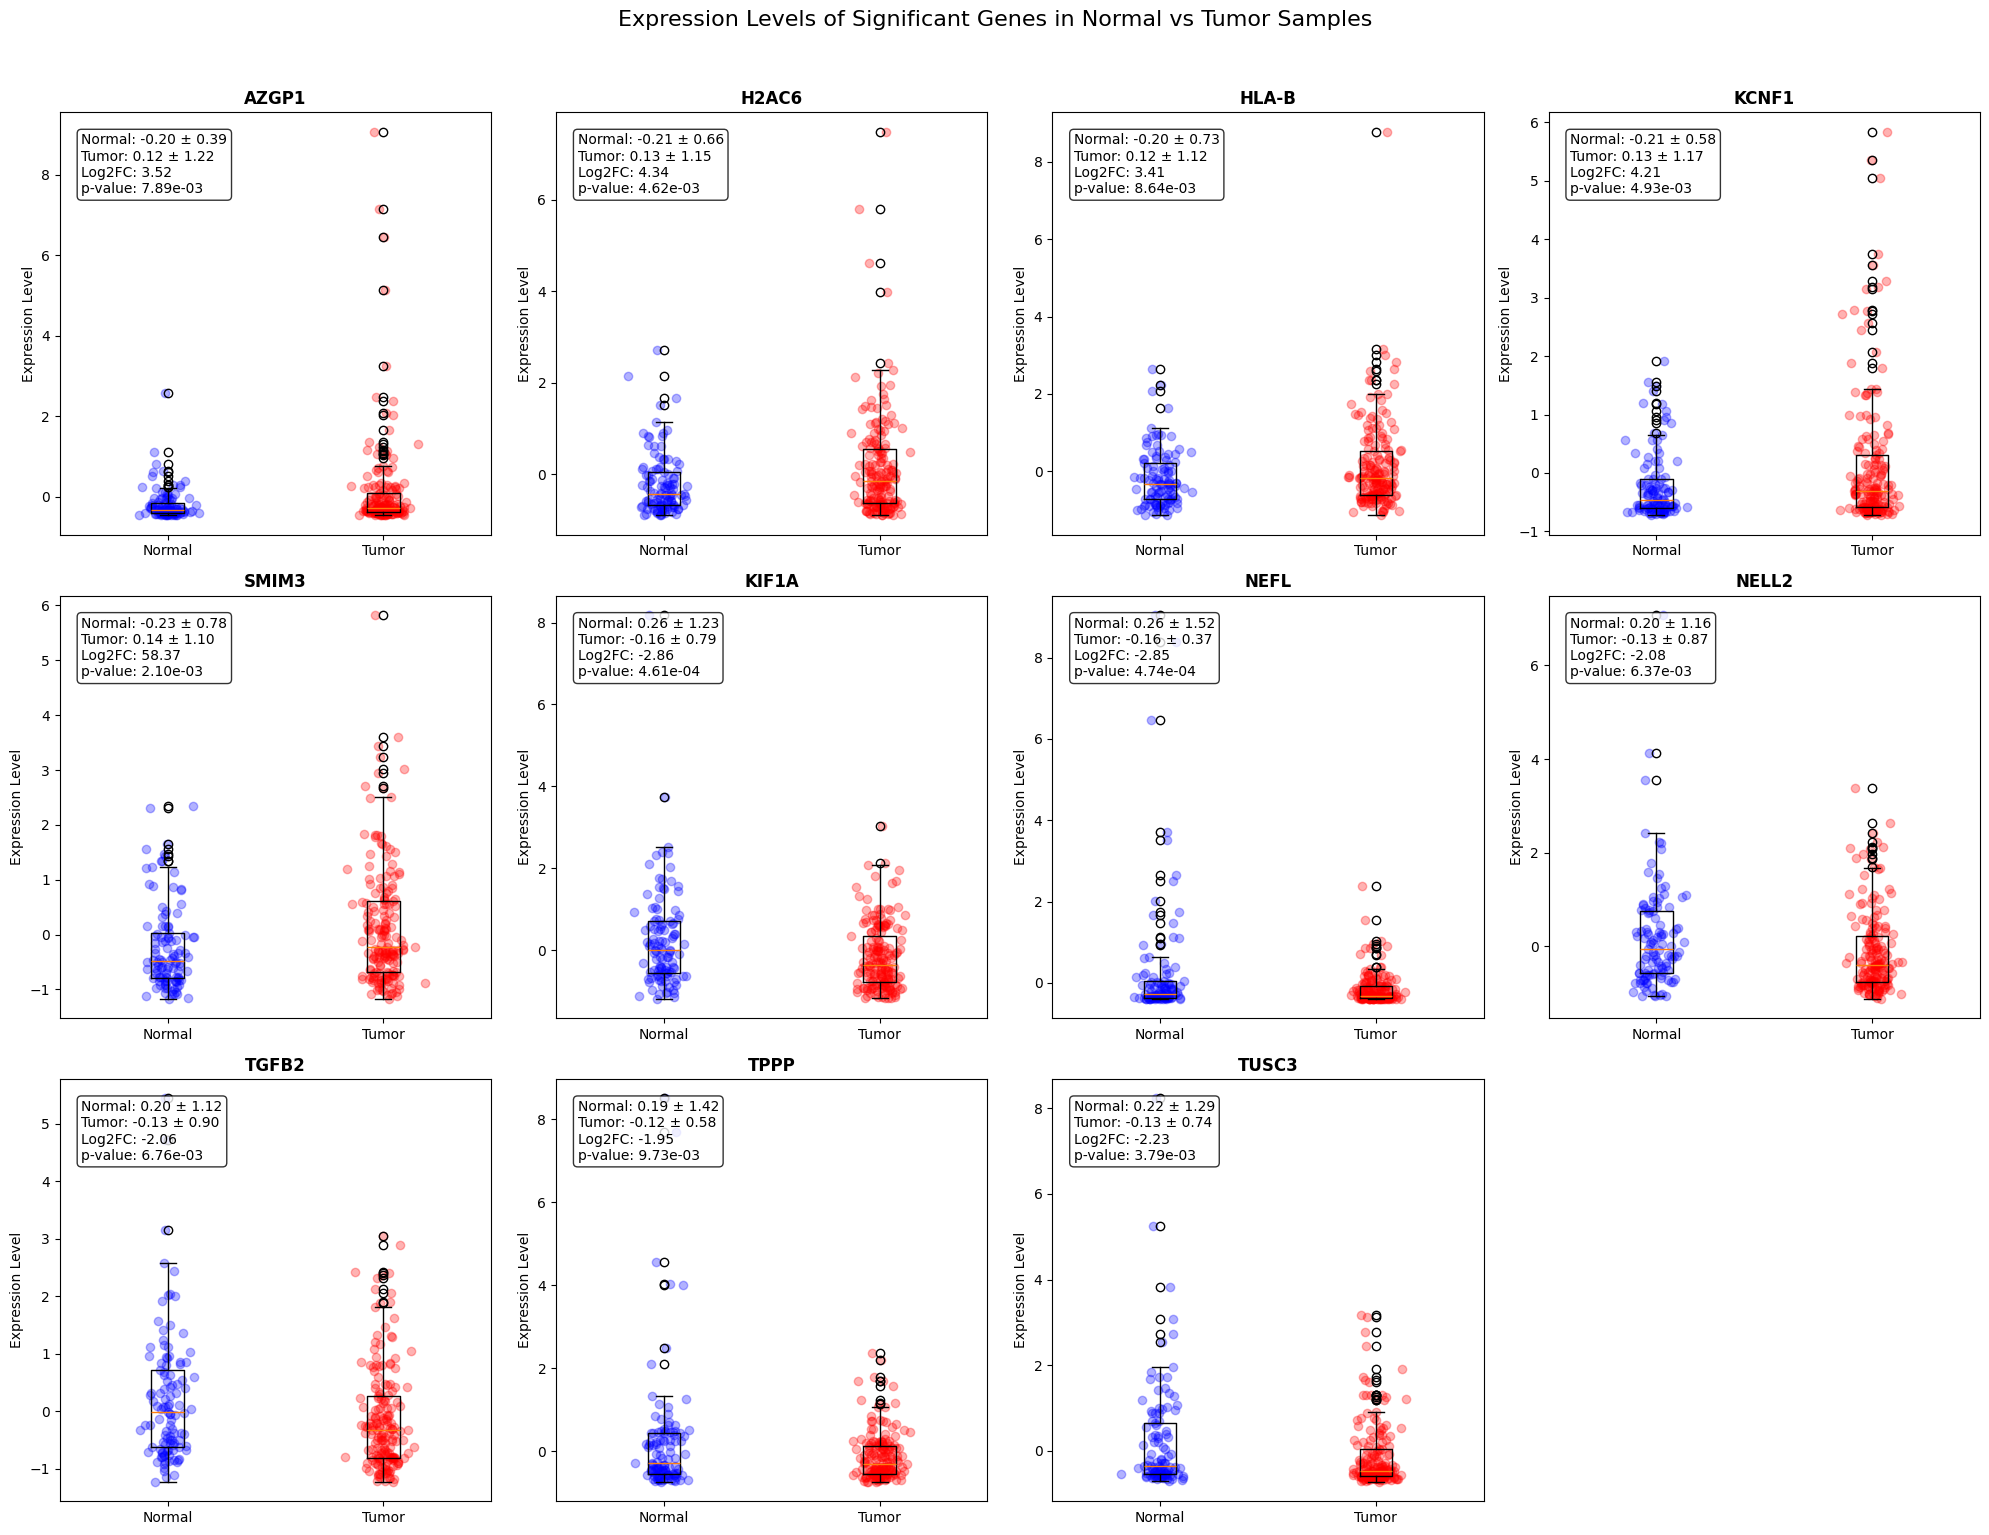


Detailed Summary Statistics:

Gene: AZGP1
----------------------------------------
Normal Samples:
  Mean ± SD: -0.199 ± 0.393
  Median: -0.331
  Range: -0.465 to 2.567
  IQR: 0.252

Tumor Samples:
  Mean ± SD: 0.123 ± 1.223
  Median: -0.273
  Range: -0.467 to 9.074
  IQR: 0.482

Differential Expression:
  Log2 Fold Change: 3.517
  p-value: 7.89e-03

Gene: H2AC6
----------------------------------------
Normal Samples:
  Mean ± SD: -0.212 ± 0.663
  Median: -0.426
  Range: -0.903 to 2.723
  IQR: 0.739

Tumor Samples:
  Mean ± SD: 0.131 ± 1.146
  Median: -0.153
  Range: -0.891 to 7.498
  IQR: 1.183

Differential Expression:
  Log2 Fold Change: 4.337
  p-value: 4.62e-03

Gene: HLA-B
----------------------------------------
Normal Samples:
  Mean ± SD: -0.196 ± 0.732
  Median: -0.340
  Range: -1.146 to 2.637
  IQR: 0.930

Tumor Samples:
  Mean ± SD: 0.122 ± 1.122
  Median: -0.175
  Range: -1.125 to 8.788
  IQR: 1.122

Differential Expression:
  Log2 Fold Change: 3.410
  p-value: 8.64e-03



In [9]:



# Create a figure with multiple subplots for each gene
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.ravel()  # Flatten the 2D array of axes for easier indexing

# Combine upregulated and downregulated genes
all_sig_genes = pd.concat([upregulated_genes, downregulated_genes])

# Create plots for each significant gene
for idx, (_, gene_info) in enumerate(all_sig_genes.iterrows()):
    gene = gene_info['Genes']
    
    # Get expression values
    normal_values = df_normal[gene]
    tumor_values = df_tumor[gene]
    plot_data = [normal_values, tumor_values]
    
    # Calculate statistics
    normal_mean = normal_values.mean()
    normal_std = normal_values.std()
    tumor_mean = tumor_values.mean()
    tumor_std = tumor_values.std()
    
    # Calculate fold change and p-value
    fold_change = gene_info['log2_fold_change']
    p_value = gene_info['p_value']
    
    # Create box plot
    axes[idx].boxplot(plot_data, labels=['Normal', 'Tumor'])
    axes[idx].set_title(f'{gene}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Expression Level')
    
    # Add individual points with jitter
    jitter = 0.05
    normal_x = np.random.normal(1, jitter, size=len(normal_values))
    tumor_x = np.random.normal(2, jitter, size=len(tumor_values))
    
    axes[idx].scatter(normal_x, normal_values, color='blue', alpha=0.3, label='Normal')
    axes[idx].scatter(tumor_x, tumor_values, color='red', alpha=0.3, label='Tumor')
    
    # Add statistics as text
    stats_text = (f'Normal: {normal_mean:.2f} ± {normal_std:.2f}\n'
                 f'Tumor: {tumor_mean:.2f} ± {tumor_std:.2f}\n'
                 f'Log2FC: {fold_change:.2f}\n'
                 f'p-value: {p_value:.2e}')
    axes[idx].text(0.05, 0.95, stats_text,
                  transform=axes[idx].transAxes,
                  verticalalignment='top',
                  bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Remove any empty subplots
for idx in range(len(all_sig_genes), len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('Expression Levels of Significant Genes in Normal vs Tumor Samples', 
            fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nDetailed Summary Statistics:")
print("=" * 80)
for _, gene_info in all_sig_genes.iterrows():
    gene = gene_info['Genes']
    normal_values = df_normal[gene]
    tumor_values = df_tumor[gene]
    
    # Calculate additional statistics
    fold_change = gene_info['log2_fold_change']
    
    print(f"\nGene: {gene}")
    print("-" * 40)
    print(f"Normal Samples:")
    print(f"  Mean ± SD: {normal_values.mean():.3f} ± {normal_values.std():.3f}")
    print(f"  Median: {normal_values.median():.3f}")
    print(f"  Range: {normal_values.min():.3f} to {normal_values.max():.3f}")
    print(f"  IQR: {normal_values.quantile(0.75) - normal_values.quantile(0.25):.3f}")
    
    print(f"\nTumor Samples:")
    print(f"  Mean ± SD: {tumor_values.mean():.3f} ± {tumor_values.std():.3f}")
    print(f"  Median: {tumor_values.median():.3f}")
    print(f"  Range: {tumor_values.min():.3f} to {tumor_values.max():.3f}")
    print(f"  IQR: {tumor_values.quantile(0.75) - tumor_values.quantile(0.25):.3f}")
    
    print(f"\nDifferential Expression:")
    print(f"  Log2 Fold Change: {fold_change:.3f}")
    print(f"  p-value: {gene_info['p_value']:.2e}")

WGCNA

C:\Users\BEK\AppData\Local\Temp\ipykernel_3740\2855411012.py:29: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(dist_matrix, method='average')
C:\Users\BEK\AppData\Local\Temp\ipykernel_3740\2855411012.py:29: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(dist_matrix, method='average')


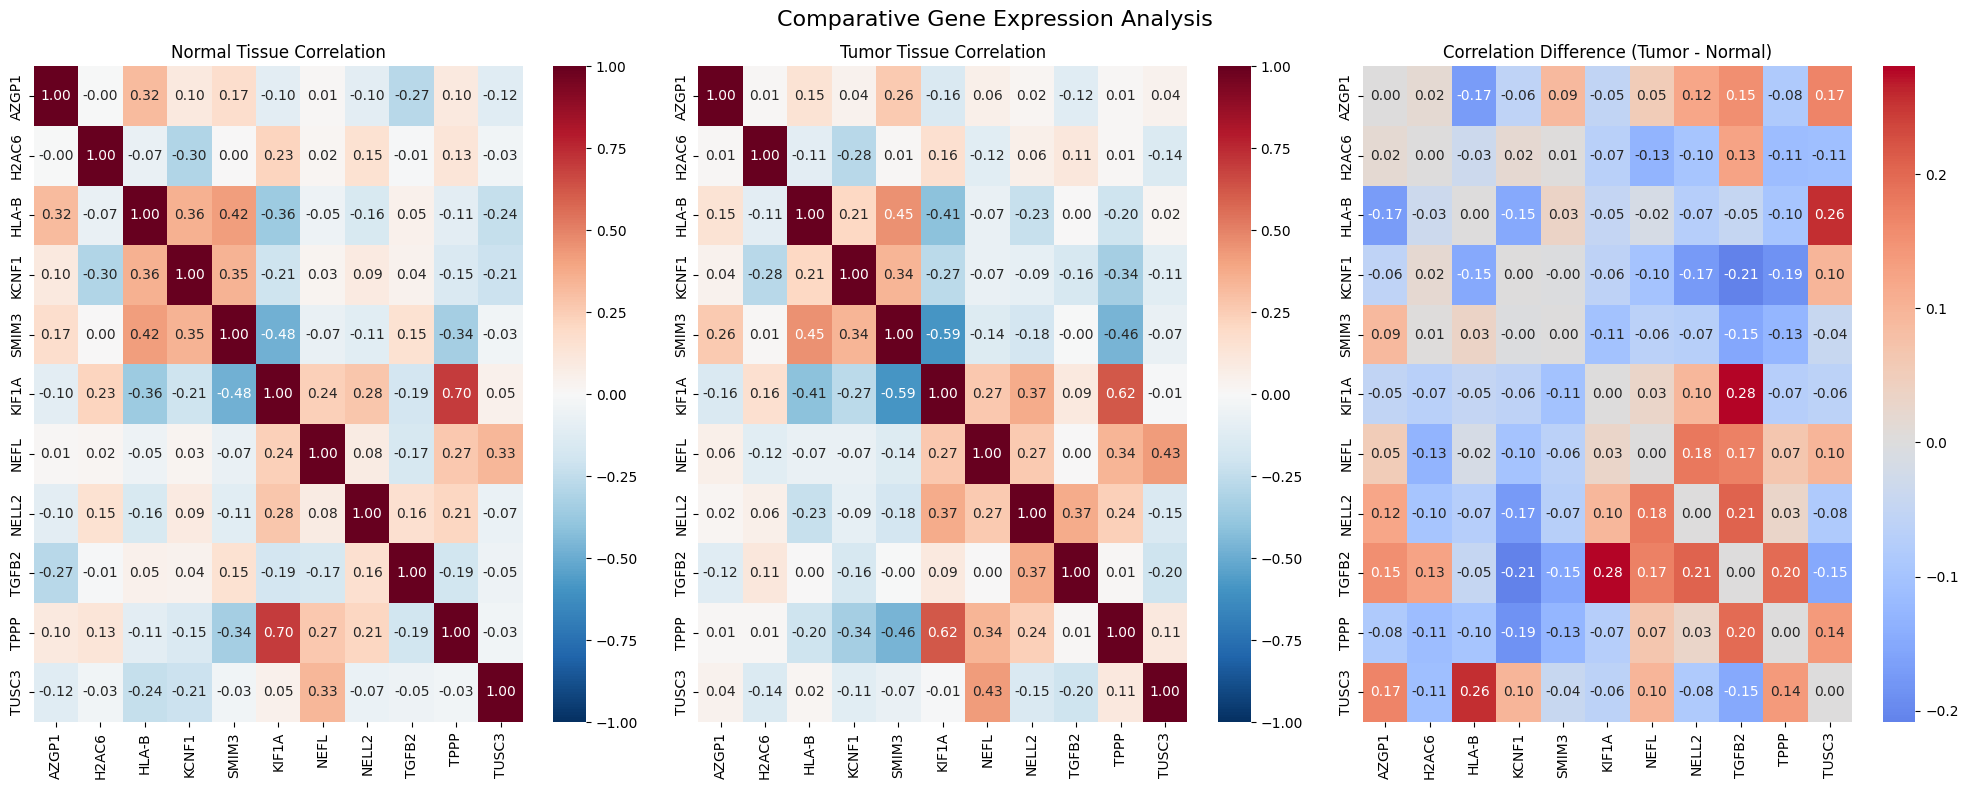

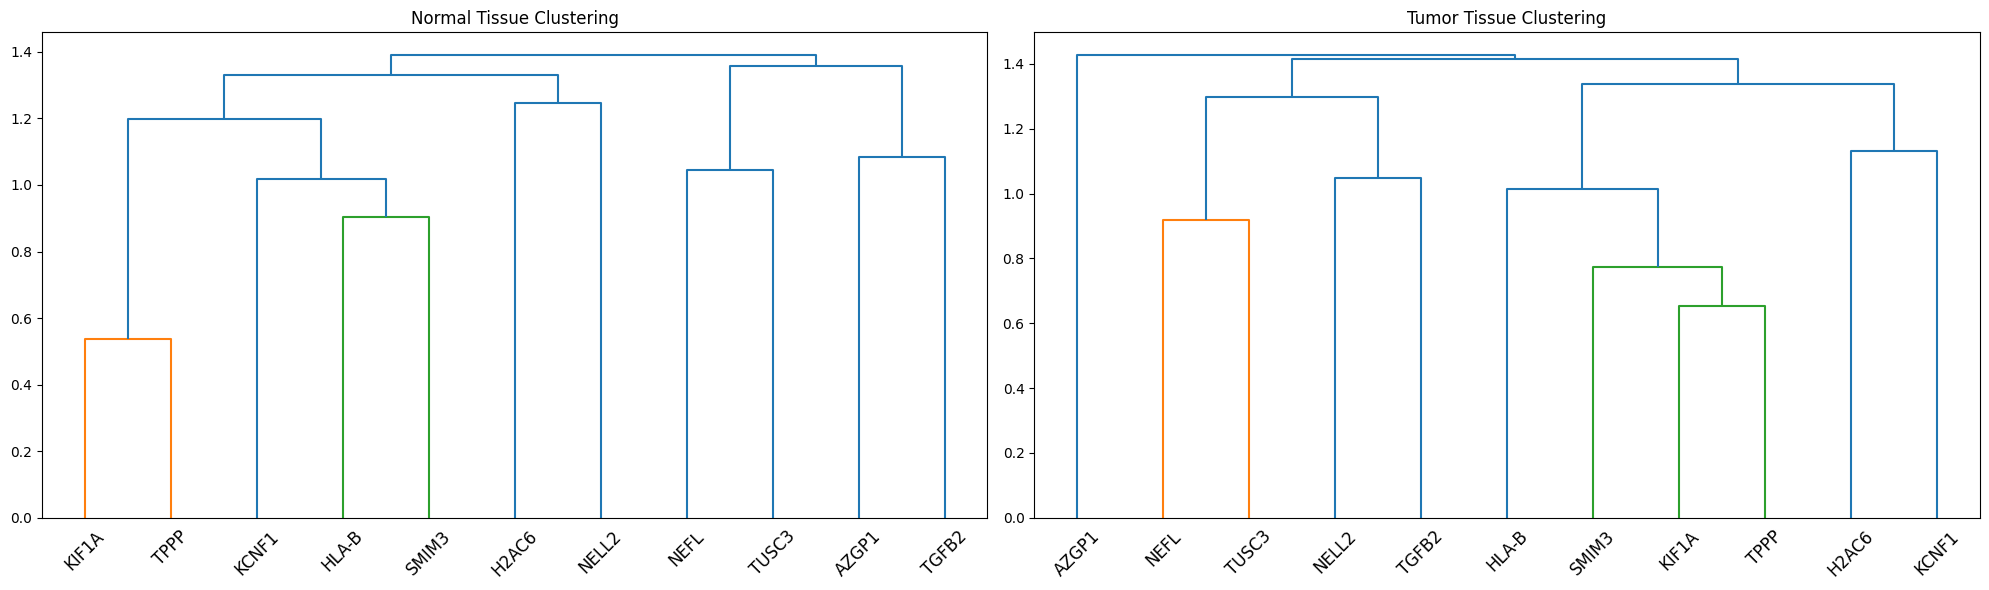

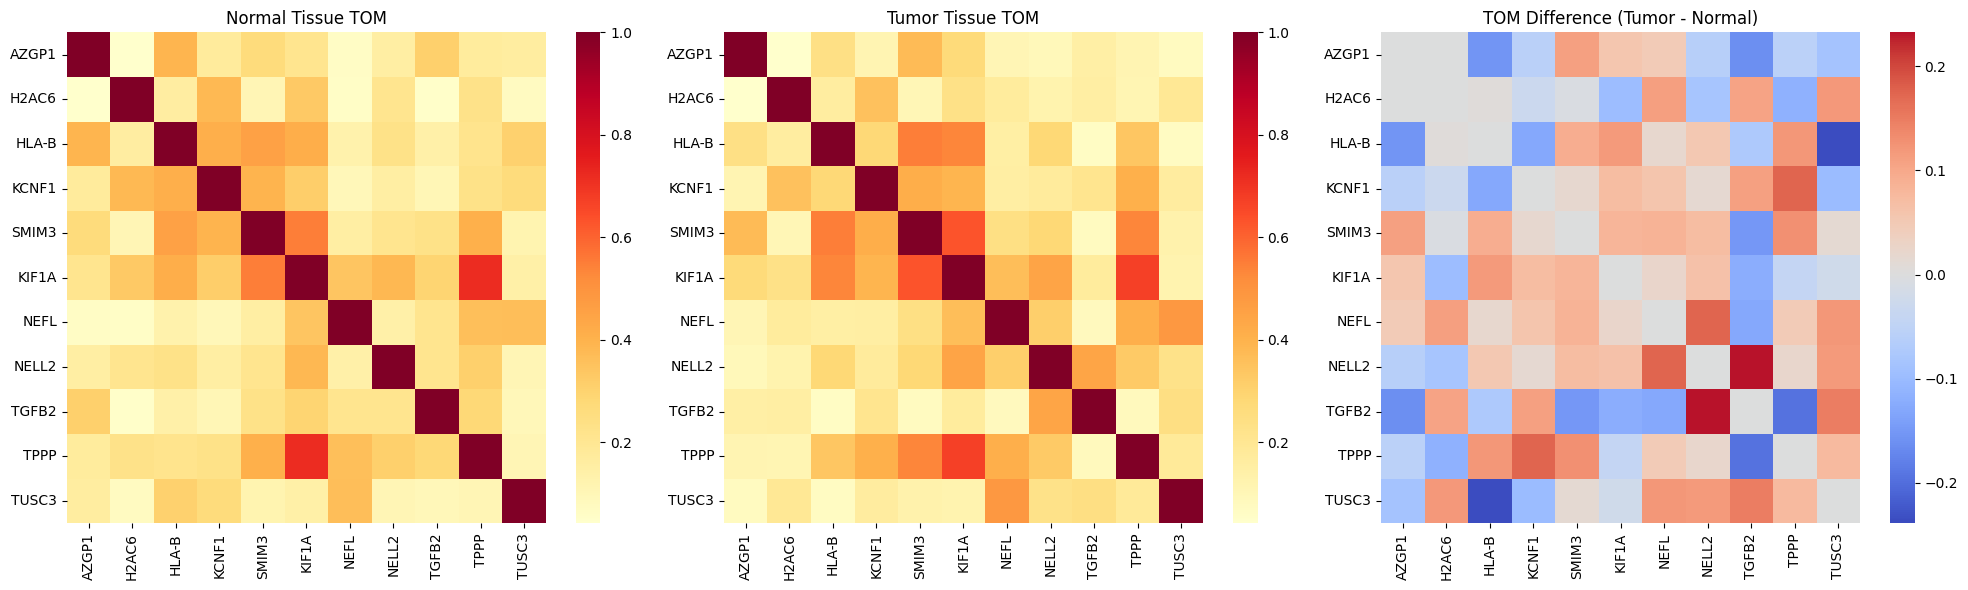

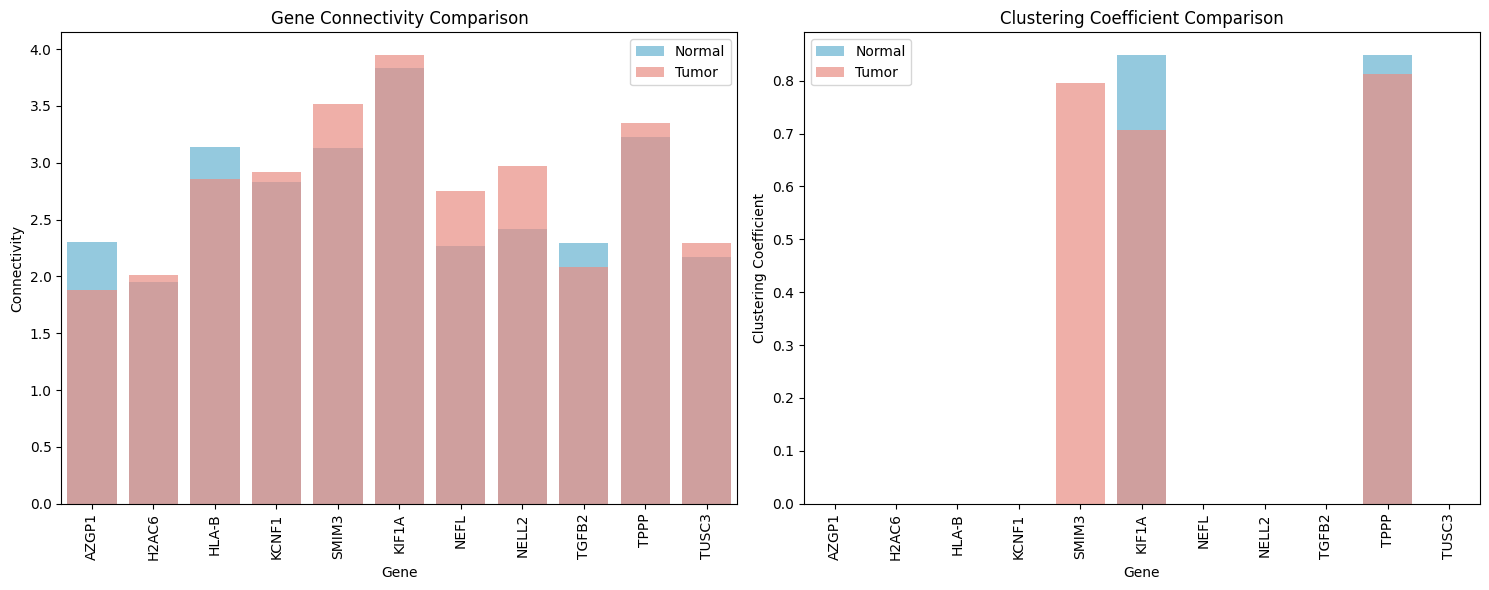

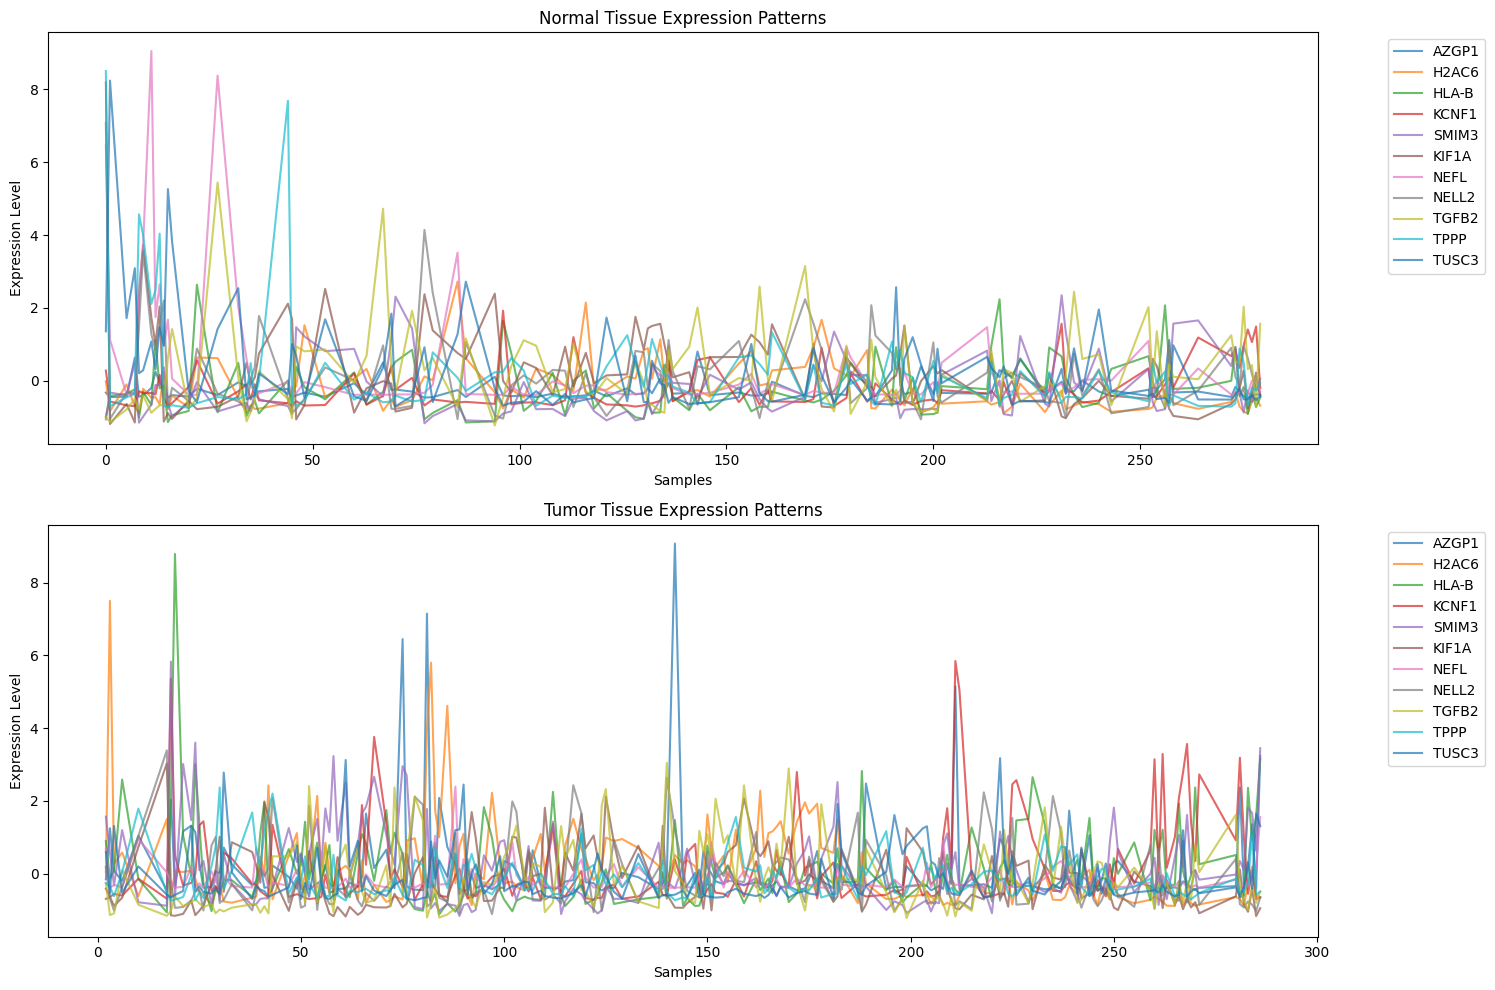


SUMMARY STATISTICS COMPARISON

Correlation Matrix Statistics:
Normal tissue: Mean = 0.104, SD = 0.351
Tumor tissue: Mean = 0.097, SD = 0.363
Absolute Difference: Mean = 0.093, Max = 0.281

TOM Statistics:
Normal tissue: Mean = 0.308, SD = 0.254
Tumor tissue: Mean = 0.320, SD = 0.261
Absolute Difference: Mean = 0.082, Max = 0.239

Gene Connectivity:
Normal tissue: Mean = 2.688, Max = 3.831
Tumor tissue: Mean = 2.780, Max = 3.951
Average Increase: 0.092

Clustering Coefficients:
Normal tissue: Mean = 0.154, Max = 0.849
Tumor tissue: Mean = 0.210, Max = 0.812
Average Change: 0.056

Genes with Largest Connectivity Increase in Tumor Tissue:
    Gene  Connectivity_Normal  Connectivity_Tumor  Connectivity_Diff
7  NELL2             2.418344            2.975060           0.556716
6   NEFL             2.267660            2.752209           0.484549
4  SMIM3             3.134013            3.518272           0.384259

Genes with Largest Clustering Coefficient Increase in Tumor Tissue:
    Gene  

In [10]:


# Prepare expression data for significant genes
sig_gene_expr = df[list(sig_gene_cols)]  # Convert tuple to list

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram

# Split data into normal and tumor tissues
df_normal = df[df['Tissue type'] == 'Normal']
df_tumor = df[df['Tissue type'] == 'Tumor']

# Check if both tissue types have data
if df_normal.empty or df_tumor.empty:
    raise ValueError("Both tissue types must have data for comparison")

# Function to analyze a single tissue type
def analyze_tissue(df_tissue, tissue_name):
    """Perform gene expression analysis for a specific tissue type"""
    results = {}
    sig_gene_expr = df_tissue[list(sig_gene_cols)]
    
    # Correlation matrix
    corr_matrix = sig_gene_expr.corr(method='spearman')
    results['corr_matrix'] = corr_matrix
    
    # Distance matrix and clustering
    dist_matrix = 1 - abs(corr_matrix)
    linkage_matrix = linkage(dist_matrix, method='average')
    results['linkage'] = linkage_matrix
    
    # TOM calculation
    n = len(corr_matrix)
    TOM = np.zeros((n, n))
    abs_corr = abs(corr_matrix)
    
    for i in range(n):
        for j in range(n):
            if i != j:
                shared = sum(abs_corr.iloc[i] * abs_corr.iloc[j])
                denominator = min(sum(abs_corr.iloc[i]), sum(abs_corr.iloc[j])) + 1 - abs_corr.iloc[i,j]
                TOM[i,j] = (shared + abs_corr.iloc[i,j]) / max(denominator, 1e-8)
            else:
                TOM[i,j] = 1
    results['TOM'] = TOM
    
    # Gene metrics
    gene_metrics = []
    for idx, gene in enumerate(sig_gene_cols):
        connectivity = sum(abs(corr_matrix.iloc[idx]))
        
        neighbors = abs(corr_matrix.iloc[idx]) > 0.5
        if sum(neighbors) > 1:
            neighbor_corrs = corr_matrix.loc[neighbors.index[neighbors], neighbors.index[neighbors]]
            clustering_coef = np.mean(abs(neighbor_corrs.values))
        else:
            clustering_coef = 0
        
        gene_metrics.append({
            'Gene': gene,
            'Connectivity': connectivity,
            'Clustering_Coefficient': clustering_coef
        })
    
    results['metrics'] = pd.DataFrame(gene_metrics)
    return results, sig_gene_expr

# Analyze both tissue types
normal_results, normal_expr = analyze_tissue(df_normal, 'Normal')
tumor_results, tumor_expr = analyze_tissue(df_tumor, 'Tumor')

# =================================================================
# COMPARATIVE VISUALIZATIONS
# =================================================================

# 1. Comparative Correlation Heatmap
plt.figure(figsize=(20, 8))
plt.suptitle('Comparative Gene Expression Analysis', fontsize=16)

# Normal tissue
plt.subplot(1, 3, 1)
sns.heatmap(normal_results['corr_matrix'], 
            cmap='RdBu_r', center=0, vmin=-1, vmax=1,
            annot=True, fmt=".2f")
plt.title('Normal Tissue Correlation')

# Tumor tissue
plt.subplot(1, 3, 2)
sns.heatmap(tumor_results['corr_matrix'], 
            cmap='RdBu_r', center=0, vmin=-1, vmax=1,
            annot=True, fmt=".2f")
plt.title('Tumor Tissue Correlation')

# Difference (Tumor - Normal)
plt.subplot(1, 3, 3)
diff_corr = tumor_results['corr_matrix'] - normal_results['corr_matrix']
sns.heatmap(diff_corr, 
            cmap='coolwarm', center=0,
            annot=True, fmt=".2f")
plt.title('Correlation Difference (Tumor - Normal)')

plt.tight_layout()
plt.show()

# 2. Comparative Dendrograms
plt.figure(figsize=(20, 6))

# Normal tissue
plt.subplot(1, 2, 1)
dendrogram(normal_results['linkage'], labels=list(sig_gene_cols))
plt.title('Normal Tissue Clustering')
plt.xticks(rotation=45)

# Tumor tissue
plt.subplot(1, 2, 2)
dendrogram(tumor_results['linkage'], labels=list(sig_gene_cols))
plt.title('Tumor Tissue Clustering')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 3. Comparative TOM Analysis
plt.figure(figsize=(20, 6))

# Normal tissue
plt.subplot(1, 3, 1)
sns.heatmap(normal_results['TOM'], 
            cmap='YlOrRd',
            xticklabels=list(sig_gene_cols),
            yticklabels=list(sig_gene_cols))
plt.title('Normal Tissue TOM')

# Tumor tissue
plt.subplot(1, 3, 2)
sns.heatmap(tumor_results['TOM'], 
            cmap='YlOrRd',
            xticklabels=list(sig_gene_cols),
            yticklabels=list(sig_gene_cols))
plt.title('Tumor Tissue TOM')

# Difference (Tumor - Normal)
plt.subplot(1, 3, 3)
diff_tom = tumor_results['TOM'] - normal_results['TOM']
sns.heatmap(diff_tom, 
            cmap='coolwarm', center=0,
            xticklabels=list(sig_gene_cols),
            yticklabels=list(sig_gene_cols))
plt.title('TOM Difference (Tumor - Normal)')

plt.tight_layout()
plt.show()

# 4. Gene Metric Comparison
metrics_combined = pd.merge(
    normal_results['metrics'], 
    tumor_results['metrics'], 
    on='Gene', 
    suffixes=('_Normal', '_Tumor')
)

# Calculate differences
metrics_combined['Connectivity_Diff'] = metrics_combined['Connectivity_Tumor'] - metrics_combined['Connectivity_Normal']
metrics_combined['Clustering_Diff'] = metrics_combined['Clustering_Coefficient_Tumor'] - metrics_combined['Clustering_Coefficient_Normal']

# Plot connectivity comparison
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.barplot(data=metrics_combined, 
            x='Gene', y='Connectivity_Normal', 
            color='skyblue', label='Normal')
sns.barplot(data=metrics_combined, 
            x='Gene', y='Connectivity_Tumor', 
            color='salmon', alpha=0.7, label='Tumor')
plt.xticks(rotation=90)
plt.ylabel('Connectivity')
plt.title('Gene Connectivity Comparison')
plt.legend()

# Plot clustering coefficient comparison
plt.subplot(1, 2, 2)
sns.barplot(data=metrics_combined, 
            x='Gene', y='Clustering_Coefficient_Normal', 
            color='skyblue', label='Normal')
sns.barplot(data=metrics_combined, 
            x='Gene', y='Clustering_Coefficient_Tumor', 
            color='salmon', alpha=0.7, label='Tumor')
plt.xticks(rotation=90)
plt.ylabel('Clustering Coefficient')
plt.title('Clustering Coefficient Comparison')
plt.legend()

plt.tight_layout()
plt.show()

# 5. Expression Pattern Comparison
plt.figure(figsize=(15, 10))

# Normal tissue expression
plt.subplot(2, 1, 1)
for gene in list(sig_gene_cols):
    plt.plot(normal_expr[gene], alpha=0.7, label=gene)
plt.title('Normal Tissue Expression Patterns')
plt.xlabel('Samples')
plt.ylabel('Expression Level')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Tumor tissue expression
plt.subplot(2, 1, 2)
for gene in list(sig_gene_cols):
    plt.plot(tumor_expr[gene], alpha=0.7, label=gene)
plt.title('Tumor Tissue Expression Patterns')
plt.xlabel('Samples')
plt.ylabel('Expression Level')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# =================================================================
# SUMMARY STATISTICS
# =================================================================
print("\n" + "="*50)
print("SUMMARY STATISTICS COMPARISON")
print("="*50)

# Correlation summary
print("\nCorrelation Matrix Statistics:")
print(f"Normal tissue: Mean = {normal_results['corr_matrix'].values.mean():.3f}, "
      f"SD = {normal_results['corr_matrix'].values.std():.3f}")
print(f"Tumor tissue: Mean = {tumor_results['corr_matrix'].values.mean():.3f}, "
      f"SD = {tumor_results['corr_matrix'].values.std():.3f}")
print(f"Absolute Difference: Mean = {abs(diff_corr).values.mean():.3f}, "
      f"Max = {abs(diff_corr).values.max():.3f}")

# TOM summary
print("\nTOM Statistics:")
print(f"Normal tissue: Mean = {normal_results['TOM'].mean():.3f}, "
      f"SD = {normal_results['TOM'].std():.3f}")
print(f"Tumor tissue: Mean = {tumor_results['TOM'].mean():.3f}, "
      f"SD = {tumor_results['TOM'].std():.3f}")
print(f"Absolute Difference: Mean = {abs(diff_tom).mean():.3f}, "
      f"Max = {abs(diff_tom).max():.3f}")

# Gene metrics summary
print("\nGene Connectivity:")
print(f"Normal tissue: Mean = {metrics_combined['Connectivity_Normal'].mean():.3f}, "
      f"Max = {metrics_combined['Connectivity_Normal'].max():.3f}")
print(f"Tumor tissue: Mean = {metrics_combined['Connectivity_Tumor'].mean():.3f}, "
      f"Max = {metrics_combined['Connectivity_Tumor'].max():.3f}")
print(f"Average Increase: {metrics_combined['Connectivity_Diff'].mean():.3f}")

print("\nClustering Coefficients:")
print(f"Normal tissue: Mean = {metrics_combined['Clustering_Coefficient_Normal'].mean():.3f}, "
      f"Max = {metrics_combined['Clustering_Coefficient_Normal'].max():.3f}")
print(f"Tumor tissue: Mean = {metrics_combined['Clustering_Coefficient_Tumor'].mean():.3f}, "
      f"Max = {metrics_combined['Clustering_Coefficient_Tumor'].max():.3f}")
print(f"Average Change: {metrics_combined['Clustering_Diff'].mean():.3f}")

# Identify most changed genes
top_connectivity = metrics_combined.nlargest(3, 'Connectivity_Diff')
print("\nGenes with Largest Connectivity Increase in Tumor Tissue:")
print(top_connectivity[['Gene', 'Connectivity_Normal', 'Connectivity_Tumor', 'Connectivity_Diff']])

top_clustering = metrics_combined.nlargest(3, 'Clustering_Diff')
print("\nGenes with Largest Clustering Coefficient Increase in Tumor Tissue:")
print(top_clustering[['Gene', 'Clustering_Coefficient_Normal', 'Clustering_Coefficient_Tumor', 'Clustering_Diff']])

# Genes with largest connectivity decrease
decreased_connectivity = metrics_combined.nsmallest(3, 'Connectivity_Diff')
print("\nGenes with Largest Connectivity Decrease in Tumor Tissue:")
print(decreased_connectivity[['Gene', 'Connectivity_Normal', 'Connectivity_Tumor', 'Connectivity_Diff']])

# Genes with largest clustering decrease
decreased_clustering = metrics_combined.nsmallest(3, 'Clustering_Diff')
print("\nGenes with Largest Clustering Coefficient Decrease in Tumor Tissue:")
print(decreased_clustering[['Gene', 'Clustering_Coefficient_Normal', 'Clustering_Coefficient_Tumor', 'Clustering_Diff']])

experimenting on how the lorentzian classification can help uncover any insight 

C:\Users\BEK\AppData\Local\Temp\ipykernel_3740\78677217.py:51: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax4.boxplot(plot_data, labels=labels, vert=False)


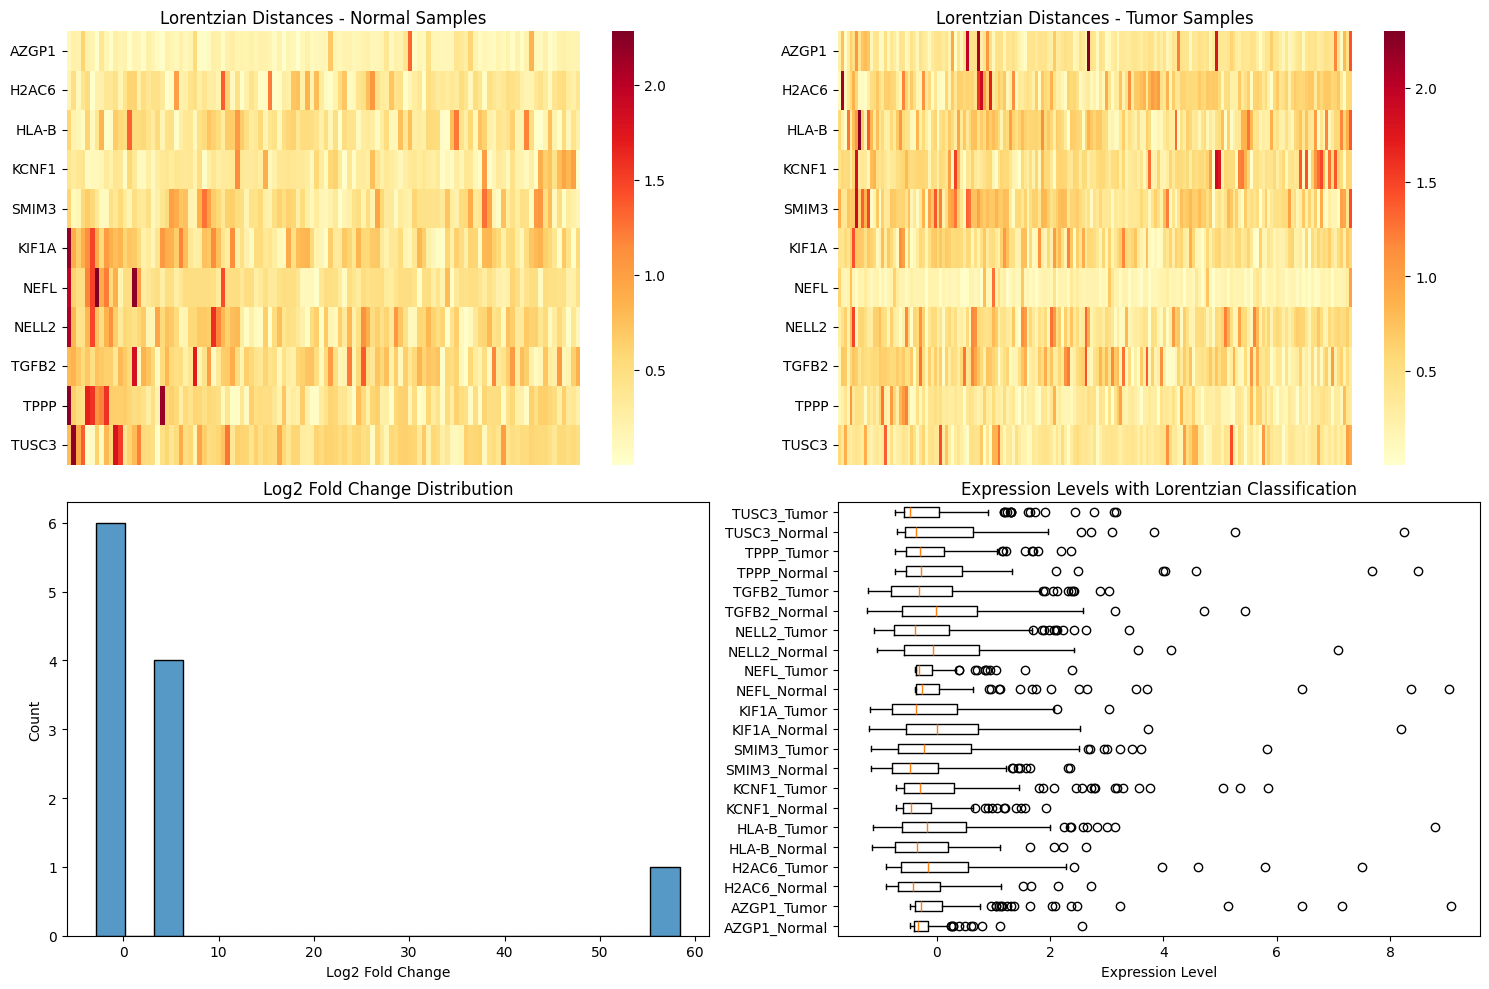


Lorentzian Classification Summary:
--------------------------------------------------

Gene: AZGP1
Normal Lorentzian Distance: 0.125
Tumor Lorentzian Distance: 0.334
Fold Change: 3.517

Gene: H2AC6
Normal Lorentzian Distance: 0.194
Tumor Lorentzian Distance: 0.251
Fold Change: 4.337

Gene: HLA-B
Normal Lorentzian Distance: 0.135
Tumor Lorentzian Distance: 0.260
Fold Change: 3.410

Gene: KCNF1
Normal Lorentzian Distance: 0.220
Tumor Lorentzian Distance: 0.361
Fold Change: 4.214

Gene: SMIM3
Normal Lorentzian Distance: 0.224
Tumor Lorentzian Distance: 0.318
Fold Change: 58.368

Gene: KIF1A
Normal Lorentzian Distance: 0.235
Tumor Lorentzian Distance: 0.192
Fold Change: -2.861

Gene: NEFL
Normal Lorentzian Distance: 0.424
Tumor Lorentzian Distance: 0.139
Fold Change: -2.853

Gene: NELL2
Normal Lorentzian Distance: 0.238
Tumor Lorentzian Distance: 0.234
Fold Change: -2.077

Gene: TGFB2
Normal Lorentzian Distance: 0.199
Tumor Lorentzian Distance: 0.177
Fold Change: -2.059

Gene: TPPP
Normal

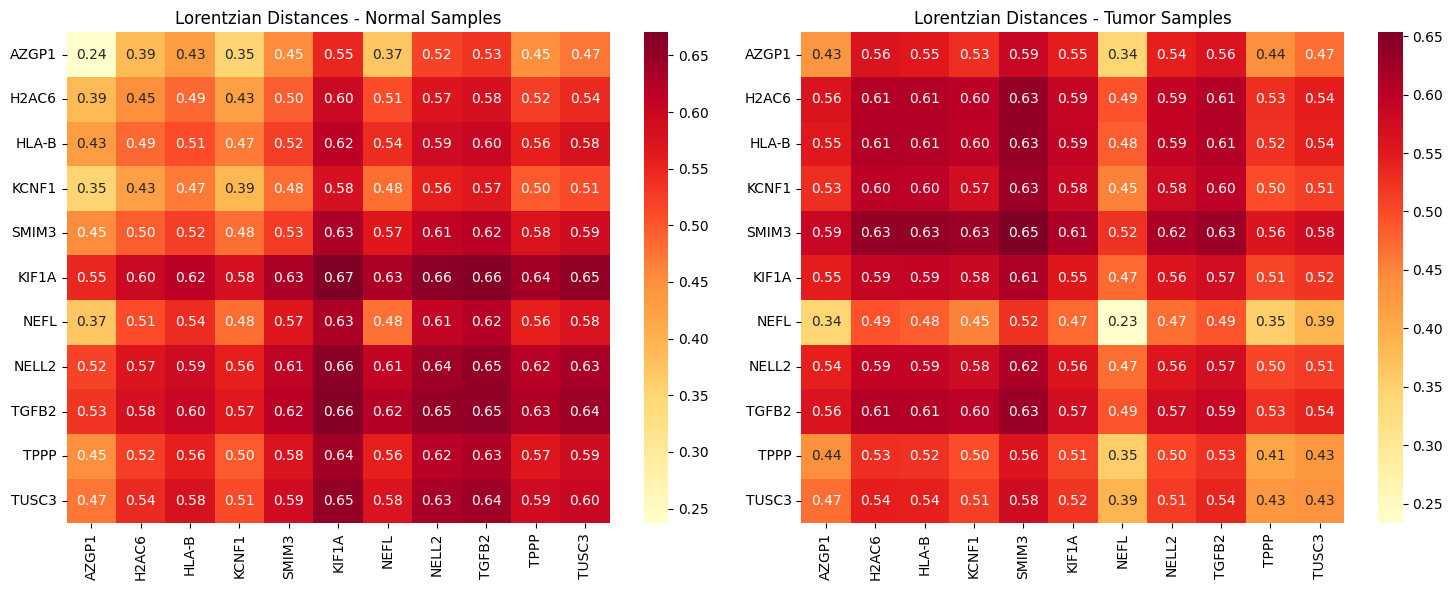


Difference in Lorentzian distances (Tumor - Normal):


,AZGP1,H2AC6,HLA-B,KCNF1,SMIM3,KIF1A,NEFL,NELL2,TGFB2,TPPP,TUSC3
AZGP1,0.194,0.172,0.122,0.175,0.133,-0.002,-0.031,0.022,0.027,-0.012,-0.005
H2AC6,0.172,0.160,0.125,0.173,0.138,-0.006,-0.017,0.019,0.027,0.003,0.001
HLA-B,0.122,0.125,0.098,0.128,0.111,-0.024,-0.060,-0.002,0.006,-0.032,-0.034
KCNF1,0.175,0.173,0.128,0.181,0.148,0.002,-0.028,0.022,0.033,0.001,-0.001
SMIM3,0.133,0.138,0.111,0.148,0.126,-0.018,-0.046,0.005,0.012,-0.016,-0.013
KIF1A,-0.002,-0.006,-0.024,0.002,-0.018,-0.116,-0.157,-0.099,-0.091,-0.132,-0.132
NEFL,-0.031,-0.017,-0.060,-0.028,-0.046,-0.157,-0.244,-0.139,-0.132,-0.203,-0.190
NELL2,0.022,0.019,-0.002,0.022,0.005,-0.099,-0.139,-0.084,-0.075,-0.114,-0.120
TGFB2,0.027,0.027,0.006,0.033,0.012,-0.091,-0.132,-0.075,-0.067,-0.102,-0.105
TPPP,-0.012,0.003,-0.032,0.001,-0.016,-0.132,-0.203,-0.114,-0.102,-0.160,-0.162



Summary of distance changes:
AZGP1 - H2AC6: 0.172
AZGP1 - HLA-B: 0.122
AZGP1 - KCNF1: 0.175
AZGP1 - SMIM3: 0.133
AZGP1 - KIF1A: -0.002
AZGP1 - NEFL: -0.031
AZGP1 - NELL2: 0.022
AZGP1 - TGFB2: 0.027
AZGP1 - TPPP: -0.012
AZGP1 - TUSC3: -0.005
H2AC6 - HLA-B: 0.125
H2AC6 - KCNF1: 0.173
H2AC6 - SMIM3: 0.138
H2AC6 - KIF1A: -0.006
H2AC6 - NEFL: -0.017
H2AC6 - NELL2: 0.019
H2AC6 - TGFB2: 0.027
H2AC6 - TPPP: 0.003
H2AC6 - TUSC3: 0.001
HLA-B - KCNF1: 0.128
HLA-B - SMIM3: 0.111
HLA-B - KIF1A: -0.024
HLA-B - NEFL: -0.060
HLA-B - NELL2: -0.002
HLA-B - TGFB2: 0.006
HLA-B - TPPP: -0.032
HLA-B - TUSC3: -0.034
KCNF1 - SMIM3: 0.148
KCNF1 - KIF1A: 0.002
KCNF1 - NEFL: -0.028
KCNF1 - NELL2: 0.022
KCNF1 - TGFB2: 0.033
KCNF1 - TPPP: 0.001
KCNF1 - TUSC3: -0.001
SMIM3 - KIF1A: -0.018
SMIM3 - NEFL: -0.046
SMIM3 - NELL2: 0.005
SMIM3 - TGFB2: 0.012
SMIM3 - TPPP: -0.016
SMIM3 - TUSC3: -0.013
KIF1A - NEFL: -0.157
KIF1A - NELL2: -0.099
KIF1A - TGFB2: -0.091
KIF1A - TPPP: -0.132
KIF1A - TUSC3: -0.132
NEFL - NELL2: -

In [11]:

sig_gene_cols = upregulated_genes['Genes'].tolist() + downregulated_genes['Genes'].tolist()

# Calculate Lorentzian distances for significant genes
def lorentzian_distance(x, y, gamma=1.0):
    return np.log(1 + np.abs(x - y) / gamma)

# Prepare data for significant genes
sig_gene_data = df[sig_gene_cols]

# Calculate Lorentzian distance matrices
lorentz_dist_normal = np.zeros((len(sig_gene_cols), len(df_normal)))
lorentz_dist_tumor = np.zeros((len(sig_gene_cols), len(df_tumor)))

for i, gene in enumerate(sig_gene_cols):
    for j in range(len(df_normal)):
        lorentz_dist_normal[i,j] = lorentzian_distance(df_normal[gene].mean(), df_normal[gene].iloc[j])
    for j in range(len(df_tumor)):
        lorentz_dist_tumor[i,j] = lorentzian_distance(df_tumor[gene].mean(), df_tumor[gene].iloc[j])

# Create visualization
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, 2)

# 1. Lorentzian distances heatmap for normal samples
ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(lorentz_dist_normal, xticklabels=False, yticklabels=sig_gene_cols, 
            cmap='YlOrRd', ax=ax1)
ax1.set_title('Lorentzian Distances - Normal Samples')

# 2. Lorentzian distances heatmap for tumor samples
ax2 = fig.add_subplot(gs[0, 1])
sns.heatmap(lorentz_dist_tumor, xticklabels=False, yticklabels=sig_gene_cols, 
            cmap='YlOrRd', ax=ax2)
ax2.set_title('Lorentzian Distances - Tumor Samples')

# 3. Fold change distribution with Lorentzian fit
ax3 = fig.add_subplot(gs[1, 0])
fold_changes = significant_genes['log2_fold_change']
sns.histplot(data=fold_changes, bins=20, ax=ax3)
ax3.set_title('Log2 Fold Change Distribution')
ax3.set_xlabel('Log2 Fold Change')

# 4. Expression levels boxplot with Lorentzian classification
ax4 = fig.add_subplot(gs[1, 1])
plot_data = []
labels = []
for gene in sig_gene_cols:
    plot_data.extend([df_normal[gene], df_tumor[gene]])
    labels.extend([f'{gene}_Normal', f'{gene}_Tumor'])

ax4.boxplot(plot_data, labels=labels, vert=False)
ax4.set_title('Expression Levels with Lorentzian Classification')
ax4.set_xlabel('Expression Level')

plt.tight_layout()
plt.show()

# Print statistical summary
print("\nLorentzian Classification Summary:")
print("-" * 50)
for gene in sig_gene_cols:
    normal_lorenz = lorentzian_distance(df_normal[gene].mean(), df_normal[gene].median())
    tumor_lorenz = lorentzian_distance(df_tumor[gene].mean(), df_tumor[gene].median())
    
    print(f"\nGene: {gene}")
    print(f"Normal Lorentzian Distance: {normal_lorenz:.3f}")
    print(f"Tumor Lorentzian Distance: {tumor_lorenz:.3f}")
    print(f"Fold Change: {significant_genes.loc[significant_genes['Genes'] == gene, 'log2_fold_change'].iloc[0]:.3f}")
    
    
    
# Calculate average Lorentzian distances between significant genes
def lorentzian_distance_matrix(data, genes, gamma=1.0):
    n_genes = len(genes)
    dist_matrix = np.zeros((n_genes, n_genes))
    
    for i in range(n_genes):
        for j in range(n_genes):
            # Calculate Lorentzian distance between gene expressions
            diff = np.abs(data[genes[i]].values.reshape(-1, 1) - data[genes[j]].values)
            dist = np.mean(np.log(1 + diff / gamma))
            dist_matrix[i, j] = dist
            
    return dist_matrix

# Calculate distance matrices for normal and tumor samples
normal_dist = lorentzian_distance_matrix(df_normal, sig_gene_cols)
tumor_dist = lorentzian_distance_matrix(df_tumor, sig_gene_cols)

# Create heatmap visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Normal samples heatmap
sns.heatmap(normal_dist, annot=True, fmt='.2f', cmap='YlOrRd', 
            xticklabels=sig_gene_cols, yticklabels=sig_gene_cols, ax=ax1)
ax1.set_title('Lorentzian Distances - Normal Samples')

# Tumor samples heatmap
sns.heatmap(tumor_dist, annot=True, fmt='.2f', cmap='YlOrRd', 
            xticklabels=sig_gene_cols, yticklabels=sig_gene_cols, ax=ax2)
ax2.set_title('Lorentzian Distances - Tumor Samples')

plt.tight_layout()
plt.show()

# Calculate and print the difference in distances
diff_matrix = tumor_dist - normal_dist
print("\nDifference in Lorentzian distances (Tumor - Normal):")
diff_df = pd.DataFrame(diff_matrix, index=sig_gene_cols, columns=sig_gene_cols)
display(diff_df.round(3))

# Print summary statistics
print("\nSummary of distance changes:")
for i in range(len(sig_gene_cols)):
    for j in range(i+1, len(sig_gene_cols)):
        gene1, gene2 = sig_gene_cols[i], sig_gene_cols[j]
        diff = diff_matrix[i,j]
        print(f"{gene1} - {gene2}: {diff:.3f}")
        



AZGP1:
Number of cases with high expression: 26
Percentage of tumor cases with high expression: 14.69%

AZGP1:
Normal - Mean: -0.199, Std: 0.393
Tumor - Mean: 0.123, Std: 1.223


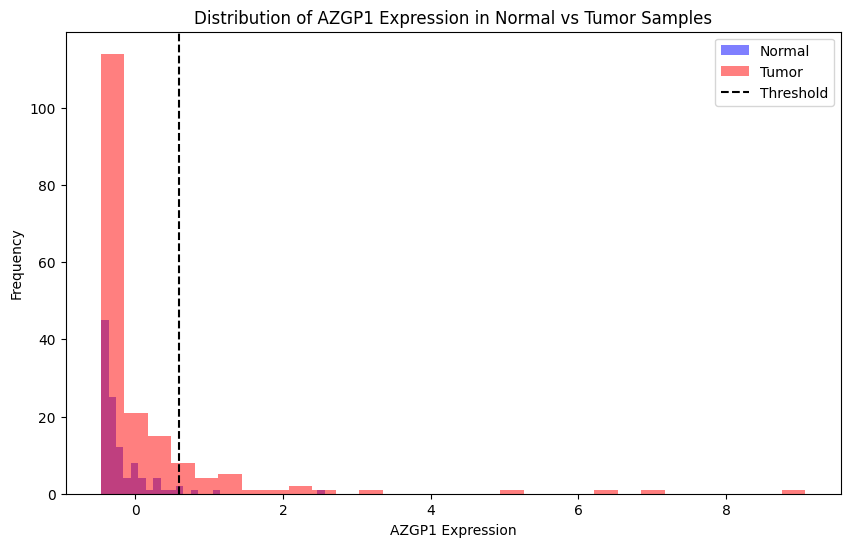


H2AC6:
Number of cases with high expression: 23
Percentage of tumor cases with high expression: 12.99%

H2AC6:
Normal - Mean: -0.212, Std: 0.663
Tumor - Mean: 0.131, Std: 1.146


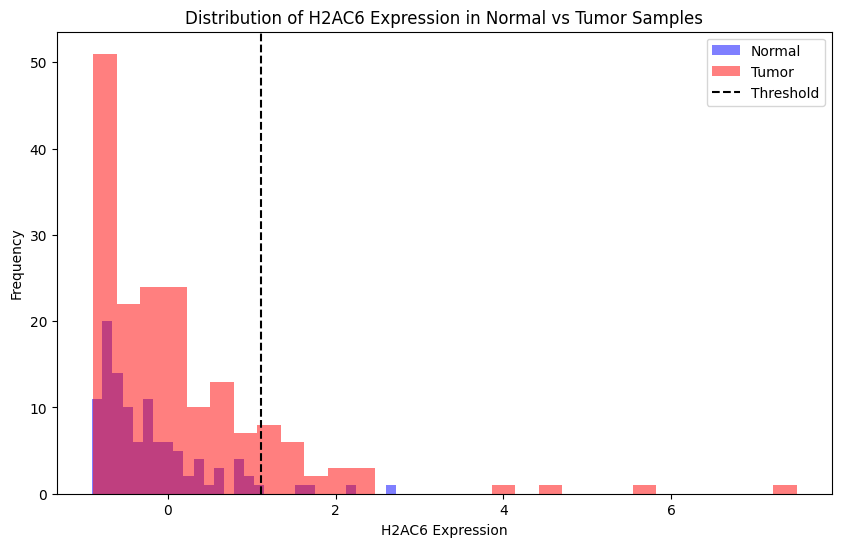


HLA-B:
Number of cases with high expression: 22
Percentage of tumor cases with high expression: 12.43%

HLA-B:
Normal - Mean: -0.196, Std: 0.732
Tumor - Mean: 0.122, Std: 1.122


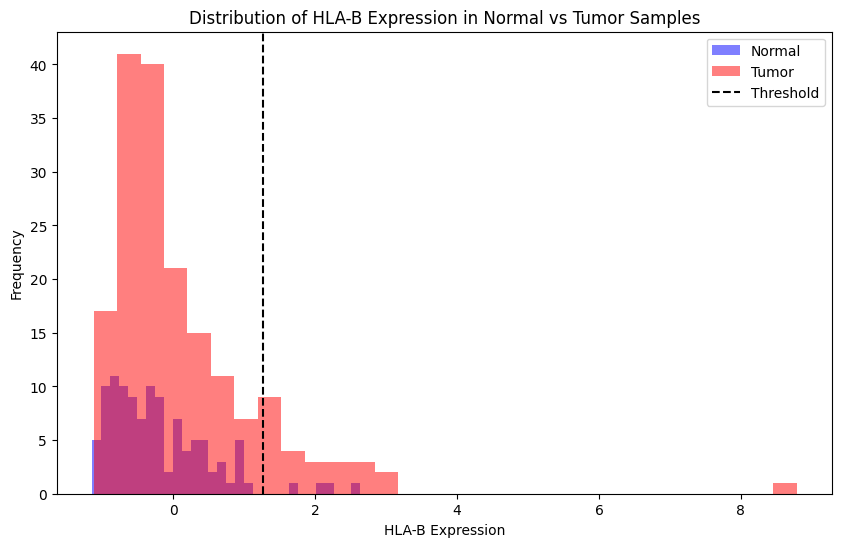


KCNF1:
Number of cases with high expression: 26
Percentage of tumor cases with high expression: 14.69%

KCNF1:
Normal - Mean: -0.210, Std: 0.582
Tumor - Mean: 0.130, Std: 1.173


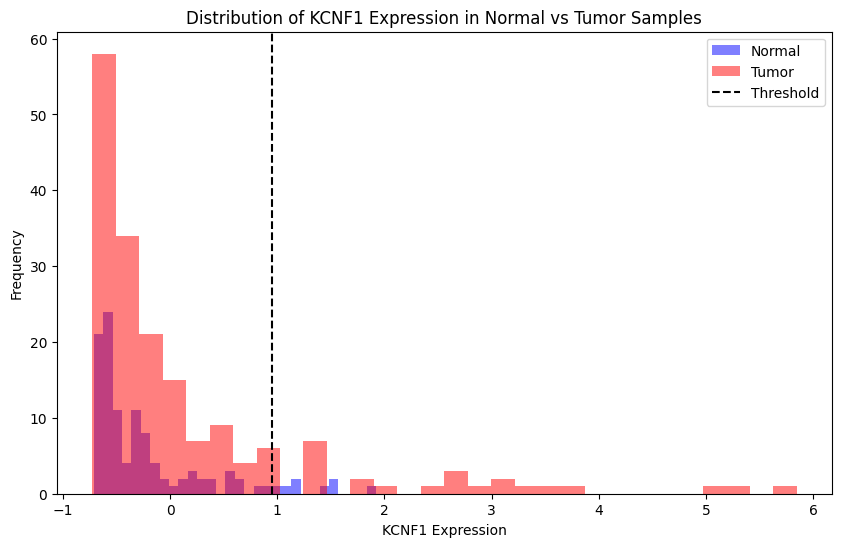


SMIM3:
Number of cases with high expression: 22
Percentage of tumor cases with high expression: 12.43%

SMIM3:
Normal - Mean: -0.229, Std: 0.781
Tumor - Mean: 0.143, Std: 1.095


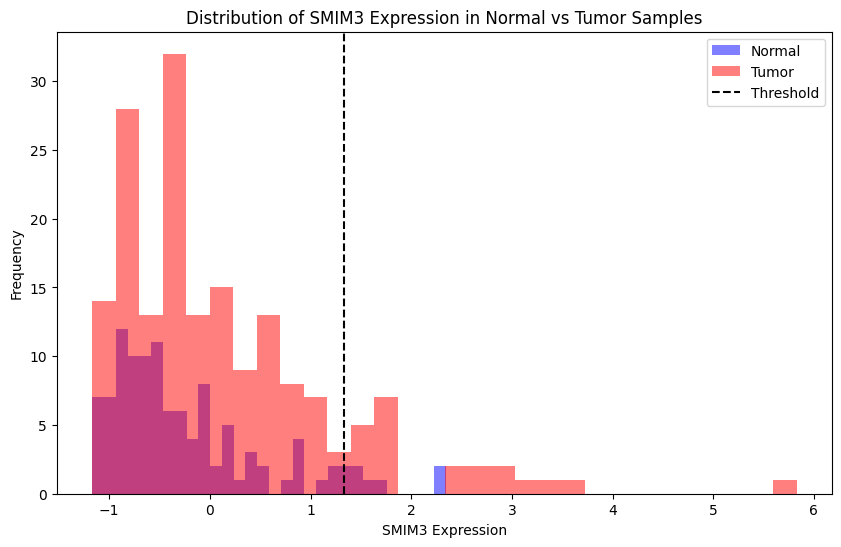

In [12]:
# For each upregulated gene, calculate number of cases with high expression
for gene in upregulated_genes['Genes']:
    # Get expression values for normal and tumor samples
    normal_values = df_normal[gene]
    tumor_values = df_tumor[gene]
    
    # Calculate threshold as mean + 2 standard deviations of normal expression
    threshold = normal_values.mean() + 2 * normal_values.std()
    
    # Count cases with high expression
    high_expr_cases = sum(tumor_values > threshold)
    
    print(f"\n{gene}:")
    print(f"Number of cases with high expression: {high_expr_cases}")
    print(f"Percentage of tumor cases with high expression: {(high_expr_cases/len(tumor_values))*100:.2f}%")
    
      # Calculate basic statistics
    normal_mean = normal_values.mean()
    normal_std = normal_values.std()
    tumor_mean = tumor_values.mean()
    tumor_std = tumor_values.std()


    # Print statistics          
    print(f"\n{gene}:")
    print(f"Normal - Mean: {normal_mean:.3f}, Std: {normal_std:.3f}")
    print(f"Tumor - Mean: {tumor_mean:.3f}, Std: {tumor_std:.3f}")
    
    
    # Plot distribution
    plt.figure(figsize=(10, 6))
    plt.hist(normal_values, bins=30, alpha=0.5, label='Normal', color='blue')
    plt.hist(tumor_values, bins=30, alpha=0.5, label='Tumor', color='red')
    plt.axvline(x=threshold, color='black', linestyle='--', label='Threshold')
    plt.xlabel(f'{gene} Expression')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {gene} Expression in Normal vs Tumor Samples')
    plt.legend()
    plt.show()

In [13]:
# Perform pathway enrichment analysis using GProfiler
gp = GProfiler(return_dataframe=True)

# Extract the list of upregulated genes
upregulated_gene_list = upregulated_genes['Genes'].tolist()
print("Upregulated Gene List:", upregulated_gene_list)

# Perform enrichment analysis for pathways
pathway_enrichment_results = gp.profile(
    query=upregulated_gene_list,
    organism='hsapiens',  # Human organism
    sources=['KEGG', 'REAC', 'WP', 'GO:BP', 'GO:MF', 'GO:CC']  # Expanded sources
)

# Check if results are empty
if pathway_enrichment_results.empty:
    print("No significant pathways found.")
else:
    # Display the top pathway enrichment results
    pathway_enrichment_results = pathway_enrichment_results.sort_values(by='p_value').head(10)
    display(pathway_enrichment_results)

Upregulated Gene List: ['AZGP1', 'H2AC6', 'HLA-B', 'KCNF1', 'SMIM3']
No significant pathways found.


In [14]:
gp = GProfiler(return_dataframe=True)
for gene in upregulated_genes['Genes']:
    print(f"\nPathway enrichment for downregulated gene: {gene}")
    result = gp.profile(
        query=[gene],
        organism='hsapiens',
        sources=['KEGG', 'REAC', 'WP', 'GO:BP', 'GO:MF', 'GO:CC']
    )
    if result.empty:
        print("  No significant pathways found.")
    else:
        display(result.sort_values(by='p_value').head(5))


Pathway enrichment for downregulated gene: AZGP1
  No significant pathways found.

Pathway enrichment for downregulated gene: H2AC6
  No significant pathways found.

Pathway enrichment for downregulated gene: HLA-B
  No significant pathways found.

Pathway enrichment for downregulated gene: KCNF1
  No significant pathways found.

Pathway enrichment for downregulated gene: SMIM3
  No significant pathways found.



KIF1A:
Number of cases with low expression: 176
Percentage of tumor cases with low expression: 99.44%

KIF1A:
Normal - Mean: 0.261, Std: 1.230
Tumor - Mean: -0.162, Std: 0.791


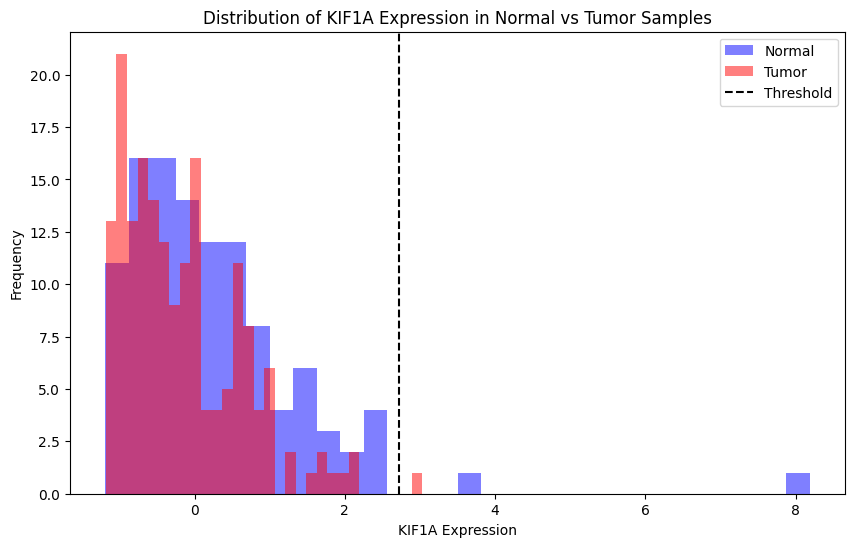


NEFL:
Number of cases with low expression: 177
Percentage of tumor cases with low expression: 100.00%

NEFL:
Normal - Mean: 0.260, Std: 1.518
Tumor - Mean: -0.162, Std: 0.369


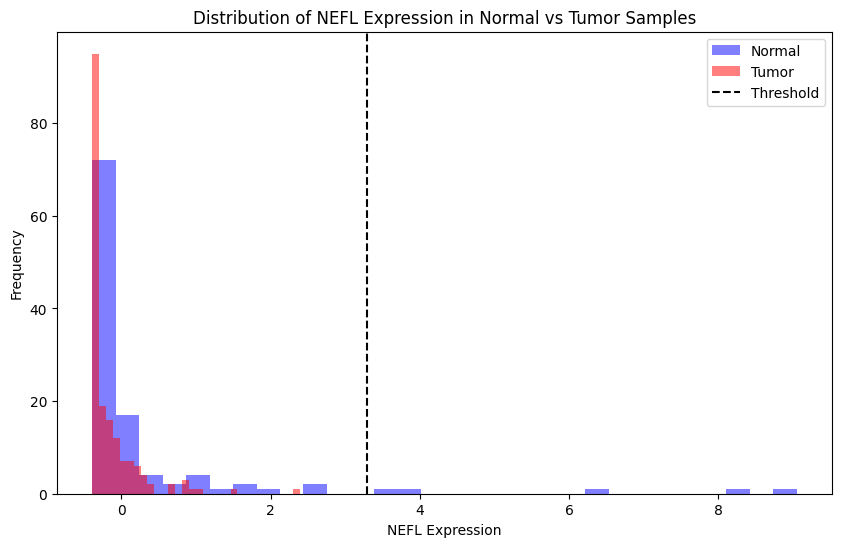


NELL2:
Number of cases with low expression: 175
Percentage of tumor cases with low expression: 98.87%

NELL2:
Normal - Mean: 0.204, Std: 1.161
Tumor - Mean: -0.127, Std: 0.868


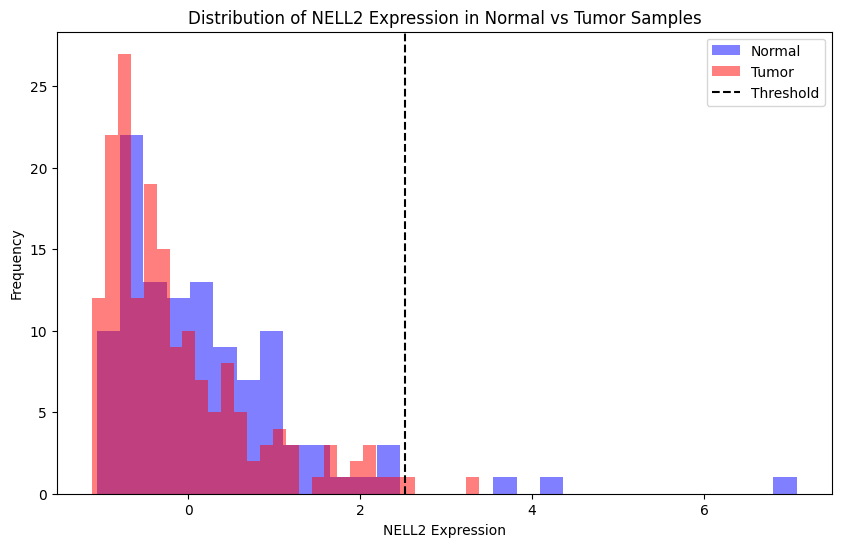


TGFB2:
Number of cases with low expression: 175
Percentage of tumor cases with low expression: 98.87%

TGFB2:
Normal - Mean: 0.202, Std: 1.117
Tumor - Mean: -0.126, Std: 0.903


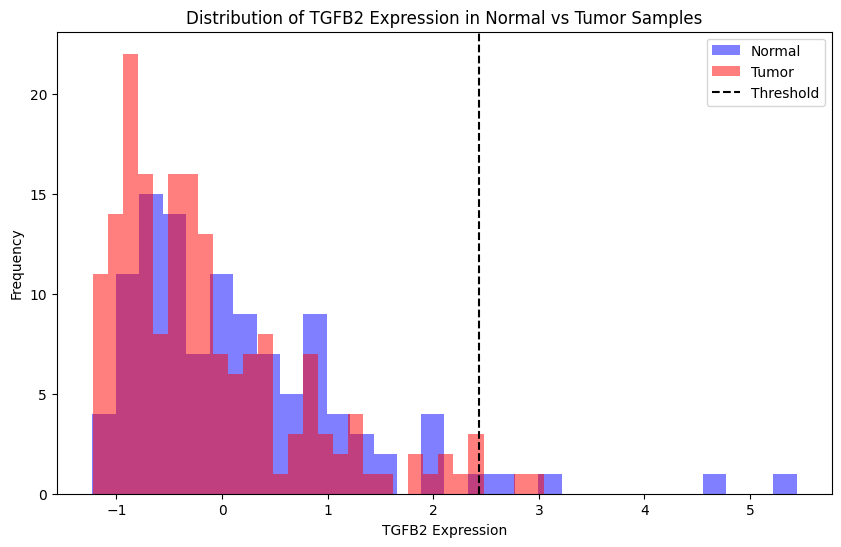


TPPP:
Number of cases with low expression: 177
Percentage of tumor cases with low expression: 100.00%

TPPP:
Normal - Mean: 0.193, Std: 1.423
Tumor - Mean: -0.120, Std: 0.582


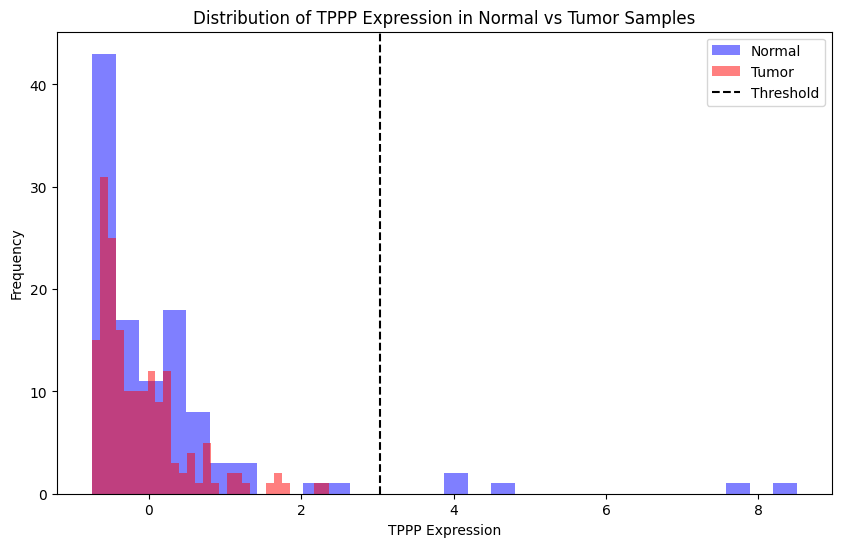


TUSC3:
Number of cases with low expression: 175
Percentage of tumor cases with low expression: 98.87%

TUSC3:
Normal - Mean: 0.216, Std: 1.291
Tumor - Mean: -0.134, Std: 0.742


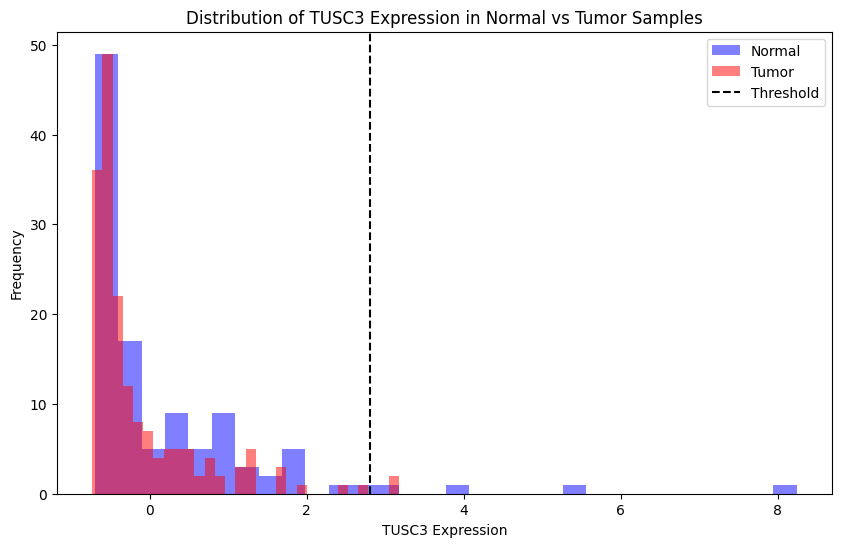

In [15]:


# For each downregulated gene, calculate number of cases with low expression
for gene in downregulated_genes['Genes']:
    # Get expression values for normal and tumor samples
    normal_values = df_normal[gene]
    tumor_values = df_tumor[gene]
    
    # Calculate threshold as mean + 2 standard deviations of normal expression
    threshold = normal_values.mean() + 2 * normal_values.std()
    
    # Count cases with low expression
    low_expr_cases = sum(tumor_values < threshold)
    
    print(f"\n{gene}:")
    print(f"Number of cases with low expression: {low_expr_cases}")
    print(f"Percentage of tumor cases with low expression: {(low_expr_cases/len(tumor_values))*100:.2f}%")
    
      # Calculate basic statistics
    normal_mean = normal_values.mean()
    normal_std = normal_values.std()
    tumor_mean = tumor_values.mean()
    tumor_std = tumor_values.std()


    # Print statistics          
    print(f"\n{gene}:")
    print(f"Normal - Mean: {normal_mean:.3f}, Std: {normal_std:.3f}")
    print(f"Tumor - Mean: {tumor_mean:.3f}, Std: {tumor_std:.3f}")
    
    
    # Plot distribution
    plt.figure(figsize=(10, 6))
    plt.hist(normal_values, bins=30, alpha=0.5, label='Normal', color='blue')
    plt.hist(tumor_values, bins=30, alpha=0.5, label='Tumor', color='red')
    plt.axvline(x=threshold, color='black', linestyle='--', label='Threshold')
    plt.xlabel(f'{gene} Expression')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {gene} Expression in Normal vs Tumor Samples')
    plt.legend()
    plt.show()

In [16]:
for gene in downregulated_genes['Genes']:
    print(f"\nPathway enrichment for downregulated gene: {gene}")
    result = gp.profile(
        query=[gene],
        organism='hsapiens',
        sources=['KEGG', 'REAC', 'WP', 'GO:BP', 'GO:MF', 'GO:CC']
    )
    if result.empty:
        print("  No significant pathways found.")
    else:
        display(result.sort_values(by='p_value').head(5))



Pathway enrichment for downregulated gene: KIF1A


,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
0,GO:CC,GO:0099012,neuronal dense core vesicle membrane,0.0498,True,"""The lipid bilayer surrounding a neuronal dens...",5,1,1,22115,1.0,0.2,query_1,"[GO:0032127, GO:0098992]"



Pathway enrichment for downregulated gene: NEFL


,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
0,GO:CC,GO:0099182,presynaptic intermediate filament cytoskeleton,0.01992,True,"""The intermediate filament cytoskeleton that i...",2,1,1,22115,1.0,0.50,query_1,"[GO:0045111, GO:0099569]"
1,GO:CC,GO:0099160,postsynaptic intermediate filament cytoskeleton,0.03984,True,"""The intermediate filament cytoskeleton that i...",4,1,1,22115,1.0,0.25,query_1,"[GO:0045111, GO:0099571]"



Pathway enrichment for downregulated gene: NELL2
  No significant pathways found.

Pathway enrichment for downregulated gene: TGFB2


,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
0,GO:BP,GO:1905006,negative regulation of epithelial to mesenchym...,0.049563,True,"""Any process that stops, prevents or reduces t...",1,1,1,21017,1.0,1.0,query_1,"[GO:0003198, GO:0062044, GO:1905005]"



Pathway enrichment for downregulated gene: TPPP


,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
0,GO:CC,GO:0150051,postsynaptic Golgi apparatus,0.009960,True,"""The network of the Golgi apparatus structures...",1,1,1,22115,1.0,1.000,query_1,"[GO:0005794, GO:0098794]"
1,GO:MF,GO:0140490,microtubule nucleator activity,0.024757,True,"""The action of a molecule that provides a shap...",1,1,1,20196,1.0,1.000,query_1,[GO:0140489]
2,GO:MF,GO:0140489,molecular template activity,0.049515,True,"""The action of a molecule that provides a shap...",2,1,1,20196,1.0,0.500,query_1,[GO:0003674]
3,WP,WP:WP2276,Glial cell differentiation,0.049958,True,Glial cell differentiation,8,1,1,8722,1.0,0.125,query_1,[WP:000000]



Pathway enrichment for downregulated gene: TUSC3
  No significant pathways found.


Here's a summary of the workflow for the glioma gene expression analysis:

1. **Data Import and Preparation**
- Imported necessary Python libraries (pandas, sklearn, matplotlib, etc.)
- Loaded glioma data from TSV file
- Separated data into normal and tumor tissue samples

2. **Principal Component Analysis (PCA)**
- Performed PCA on gene expression data
- Created visualization showing separation between normal and tumor samples
- Calculated and displayed explained variance ratios

3. **Differential Expression Analysis**
- Calculated log2 fold changes between tumor and normal samples
- Computed statistical significance (p-values) using t-tests
- Generated volcano plot showing:
  * Significantly upregulated genes (red)
  * Significantly downregulated genes (blue)
  * Non-significant genes (grey)

4. **Gene Expression Characterization**
- Identified and saved lists of upregulated and downregulated genes
- For each significant gene:
  * Calculated expression thresholds
  * Determined number of cases with altered expression
  * Generated distribution plots comparing normal vs tumor expression
  * Computed basic statistics (mean, standard deviation)

5. **Pathway Enrichment Analysis**
- Used GProfiler for pathway analysis
- Analyzed upregulated genes as a group
- Performed individual analysis for each downregulated gene
- Examined multiple pathway databases:
  * KEGG
  * Reactome
  * WikiPathways
  * Gene Ontology (Biological Process, Molecular Function, Cellular Component)

This workflow represents a comprehensive analysis of gene expression differences between normal and tumor samples, including both individual gene characterization and pathway-level insights.